In [7]:
suppressMessages(library(Seurat))
suppressMessages(library(ggplot2))
suppressMessages(library(dplyr))
suppressMessages(library(cowplot))
suppressMessages(library(gprofiler2))
suppressMessages(library(textshape))
suppressMessages(library(ggrepel))
suppressMessages(library(ComplexHeatmap))
suppressMessages(library(circlize))
suppressMessages(library(scMEGA))
suppressMessages(library(ArchR))

In [3]:
in_dir <- "../../results/05_fibroblast/04_trajectory"

In [45]:
out_dir <- "../../results/05_fibroblast/05_go_analysis"

if(!dir.exists(out_dir)){
    dir.create(out_dir, recursive = TRUE)
}

In [4]:
obj <- readRDS(glue::glue('{in_dir}/fibroblast.traj.rds'))

In [8]:
traj <- GetTrajectory(obj, assay = 'RNA', smoothWindow = 11)

Creating Trajectory Group Matrix..

Smoothing...



In [9]:
mat <- TrajectoryHeatmap(traj, labelTop=100, varCutOff=0.9, returnMatrix = TRUE)

Removing rows without peaks...

Preparing Main Heatmap..

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.



In [32]:
df <- as.data.frame(rownames(mat))
colnames(df) <- c("gene")
df$cluster <- "cluster"

In [34]:
df1 <- df[1:500, ]
df2 <- df[500:1000, ]
df3 <- df[1000:nrow(df), ]

In [37]:
df1$cluster <- "early"
df2$cluster <- "intermediate"
df3$cluster <- "late"

In [38]:
df <- rbind(df1, df2, df3)

In [43]:
df_go <- lapply(unique(df$cluster), function(x){
    df_sub <- subset(df, cluster == x)
    
    gostres <- gost(query = df_sub$gene,
                organism = "hsapiens",
               correction_method = "fdr",
               ordered_query = FALSE,
               significant = FALSE,
               measure_underrepresentation = FALSE)
    
    df_res <- gostres$result
    df_res$cluster <- x
    return(df_res)

}) %>% Reduce(rbind, .) %>%
    subset(., select = c("p_value", "source", "term_name", "cluster"))

In [46]:
head(df_go)

p_value    source term_name                    cluster
1 0.03932855 CORUM  HEXA-HEXB complex            early  
2 0.03932855 CORUM  60S APC containing complex   early  
3 0.03932855 CORUM  Emerin architectural complex early  
4 0.03932855 CORUM  ITGB6-FYN-FN1 complex        early  
5 0.03932855 CORUM  PRRX2-UCHL1 complex          early  
6 0.03932855 CORUM  APC-IQGAP1-CLIP-170 complex  early

In [47]:
write.csv(df_go, "../../results/05_fibroblast/05_go_analysis/GO_analysis.csv")

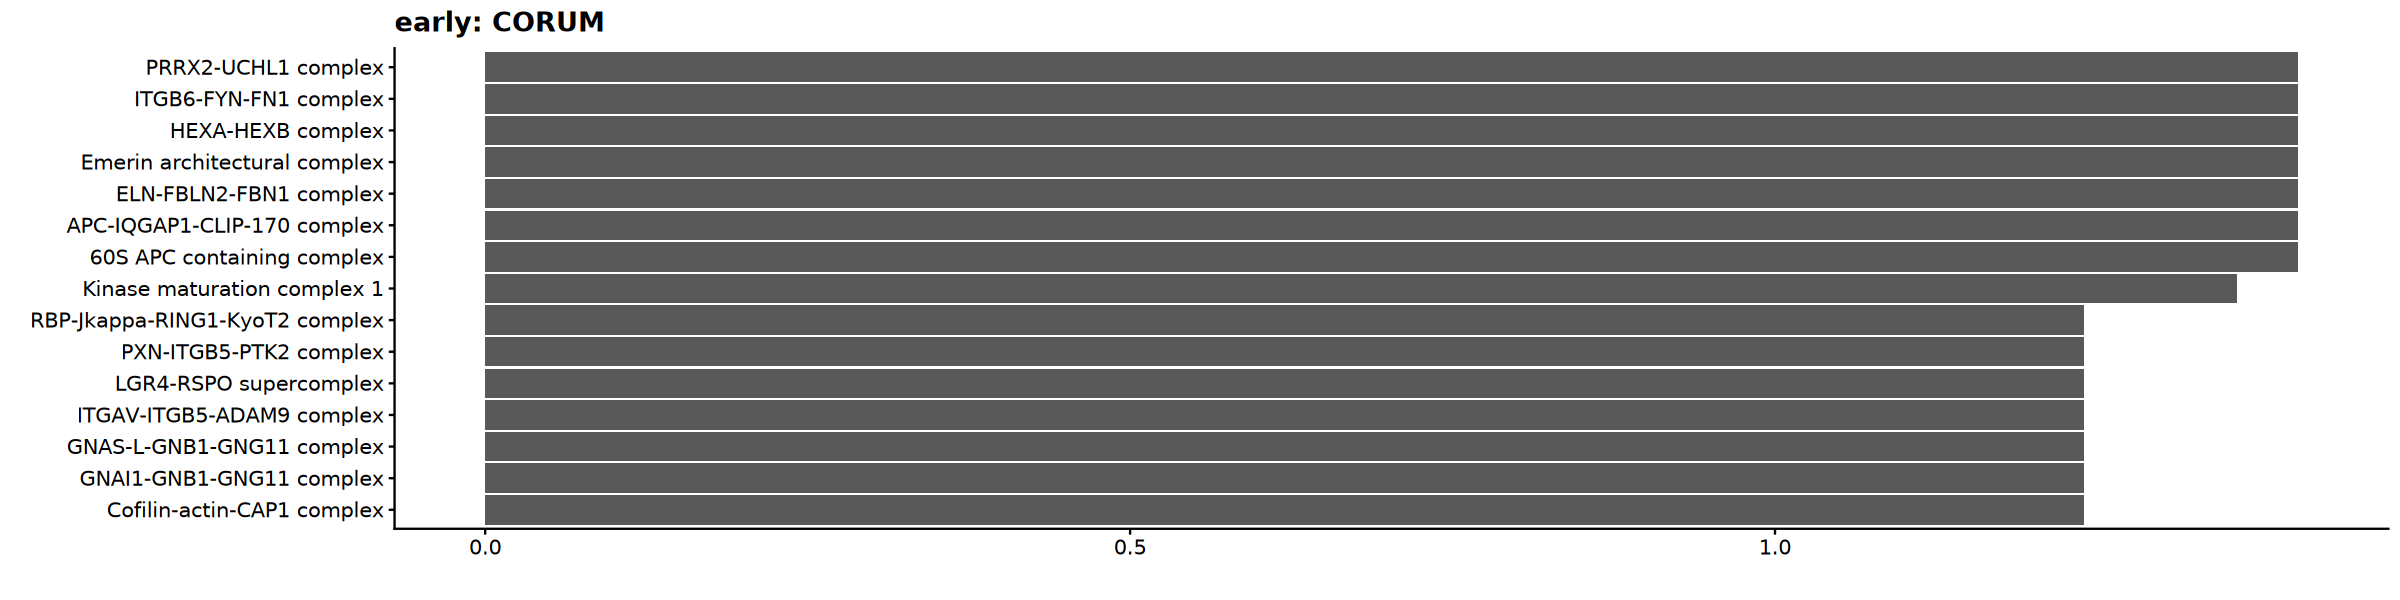

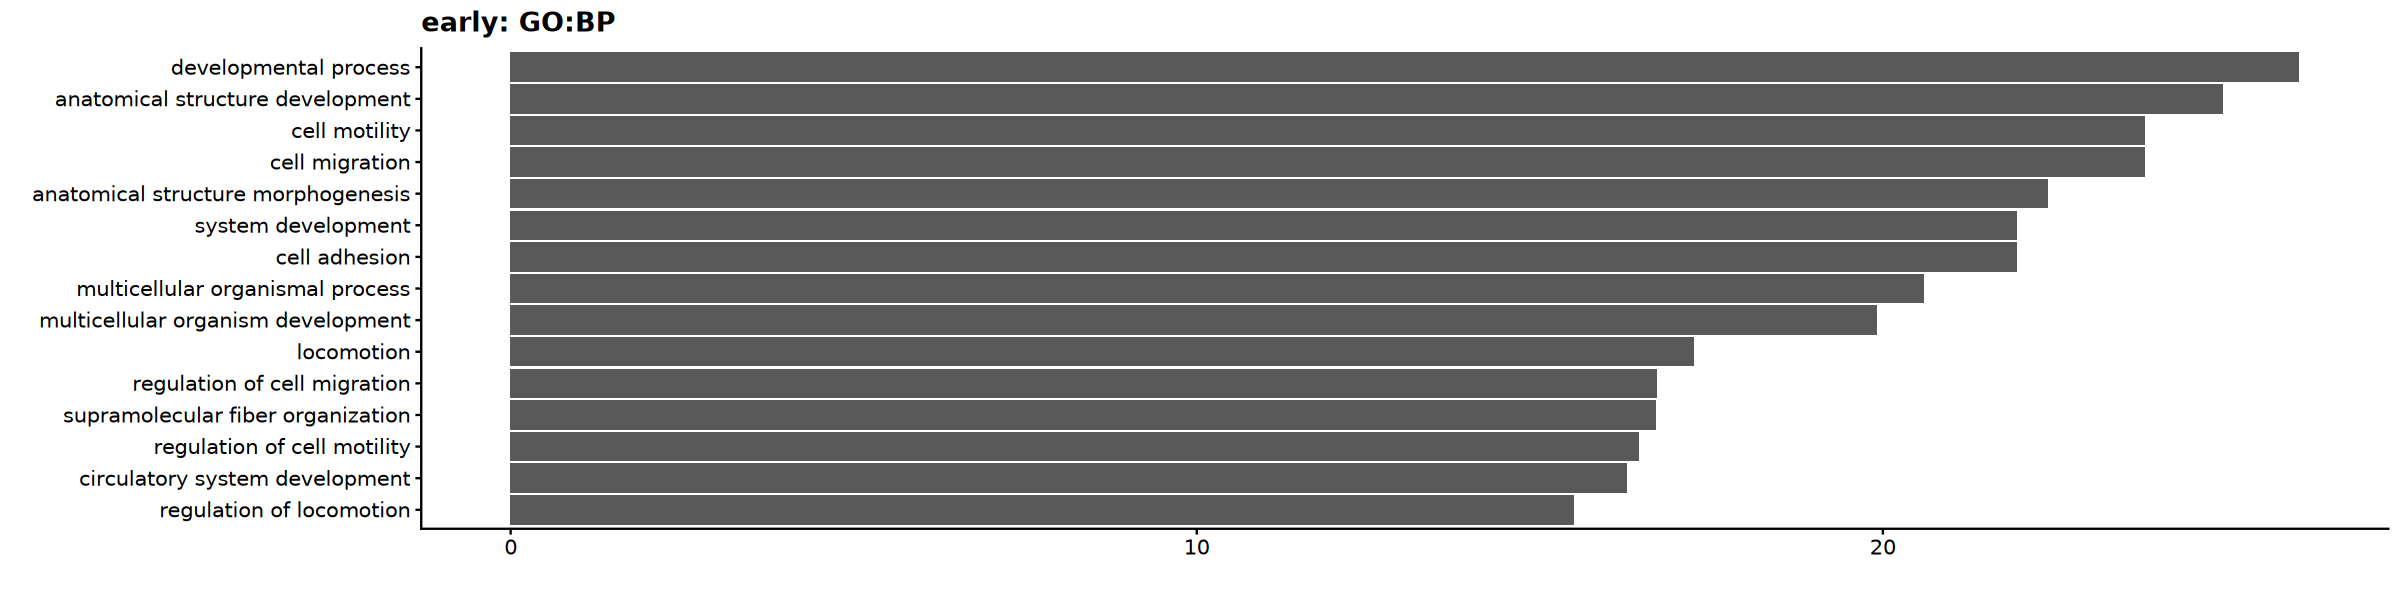

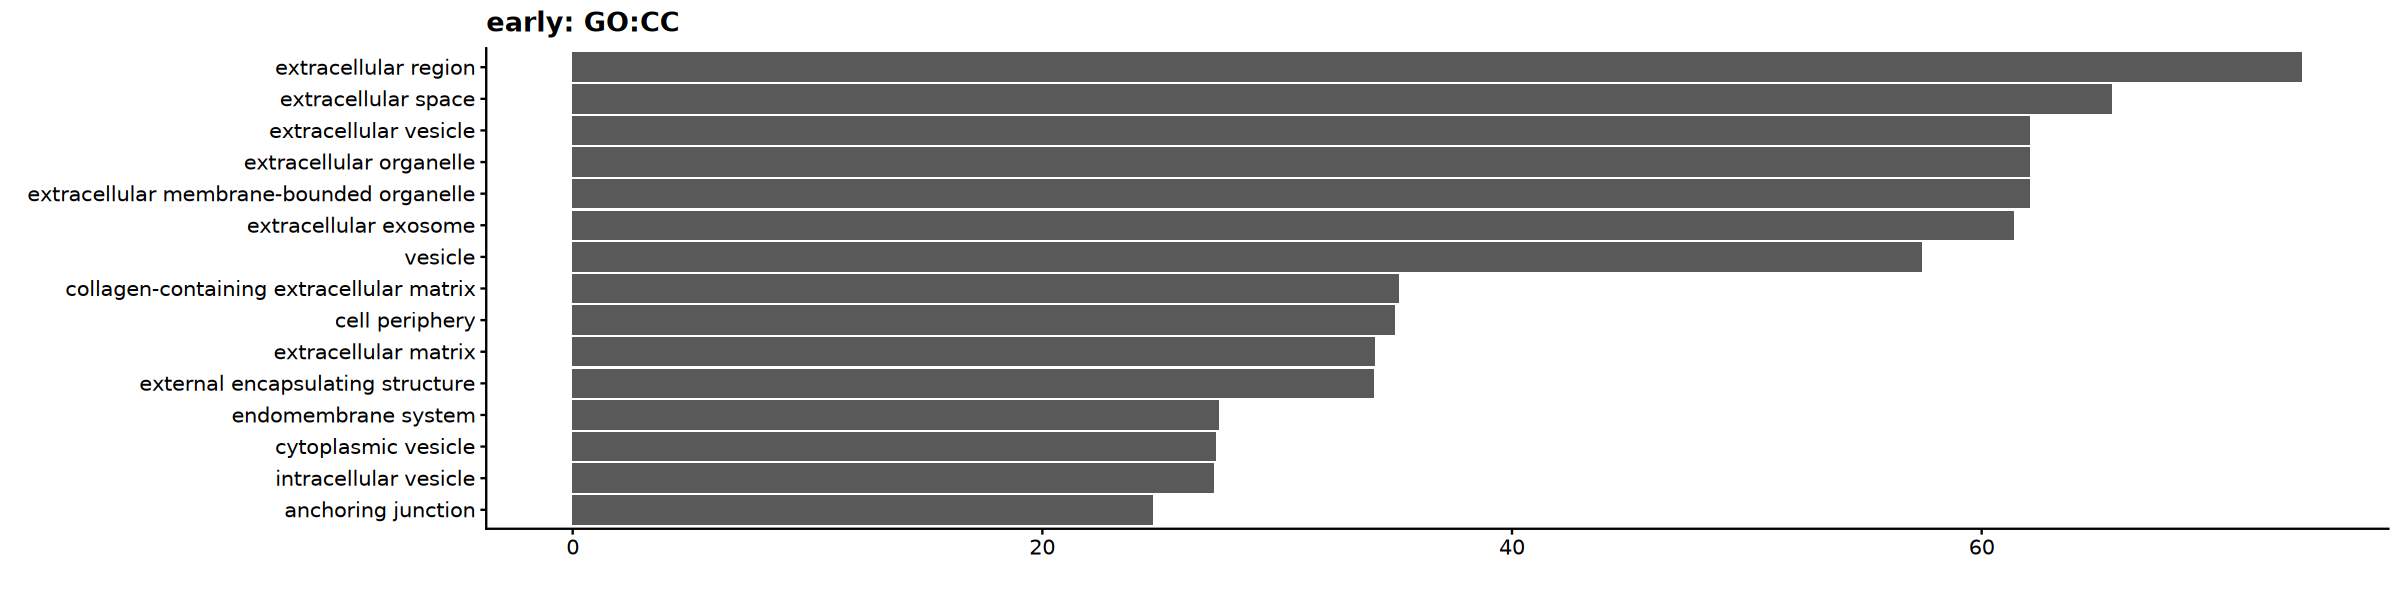

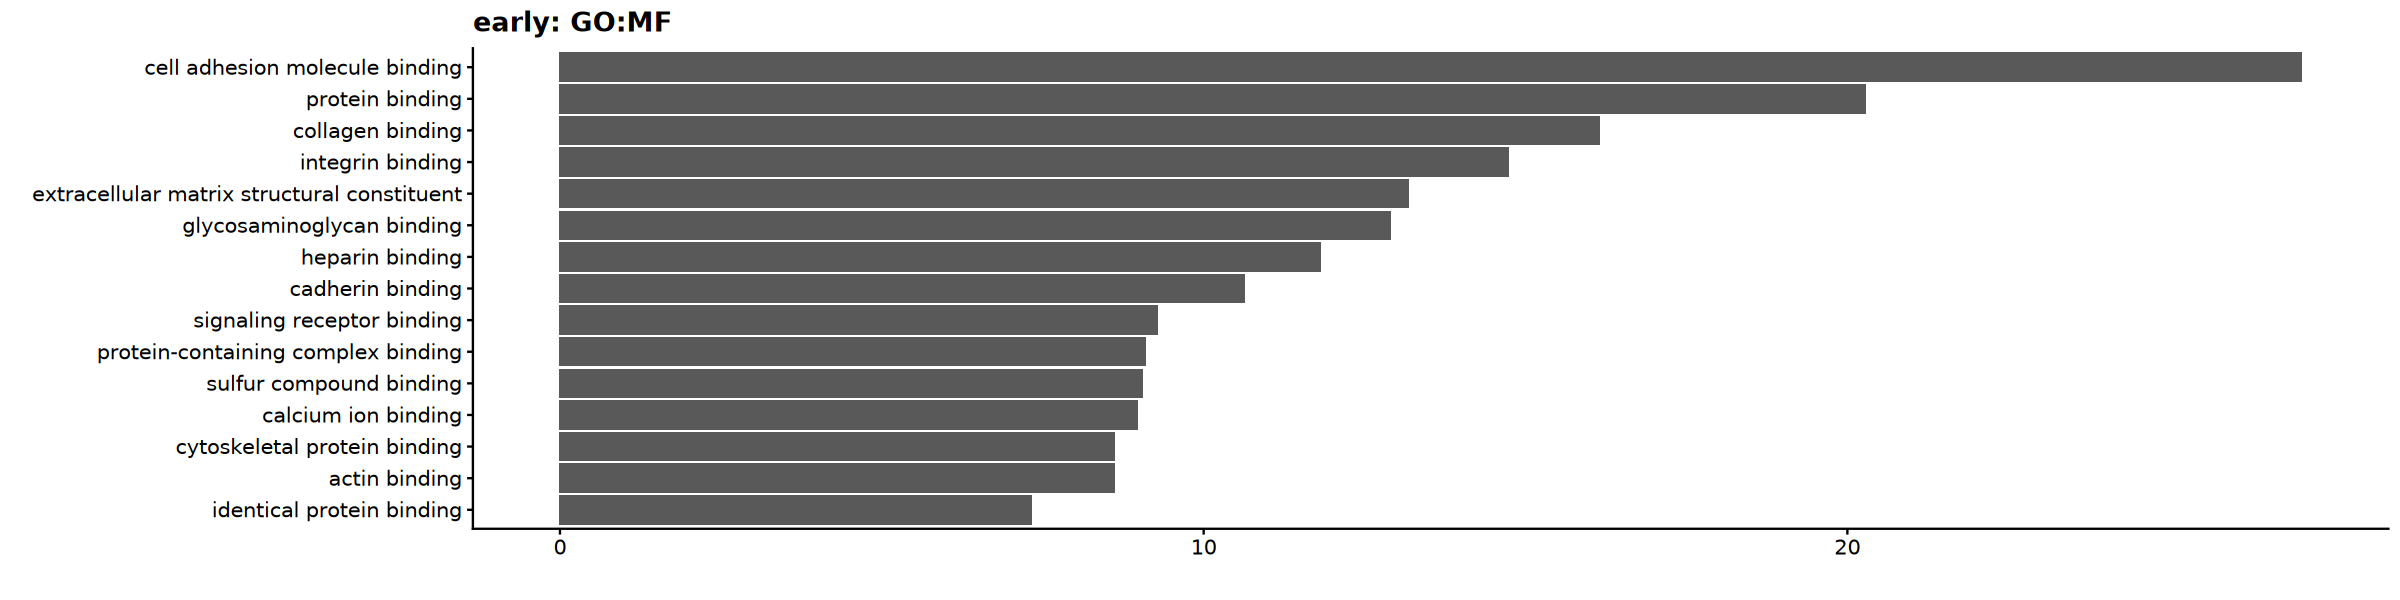

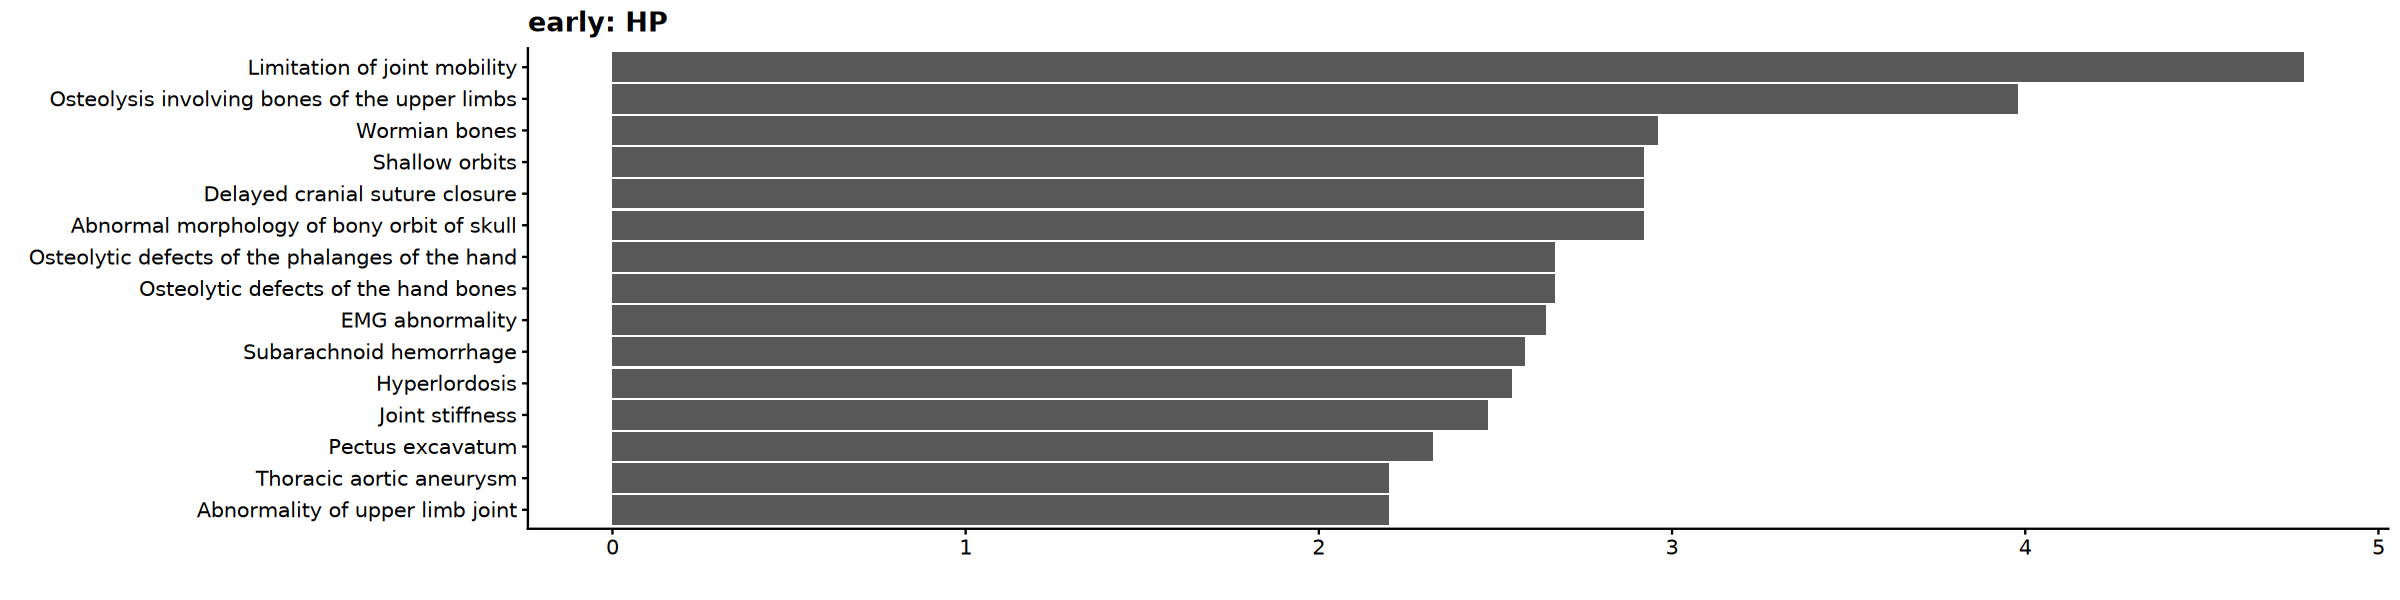

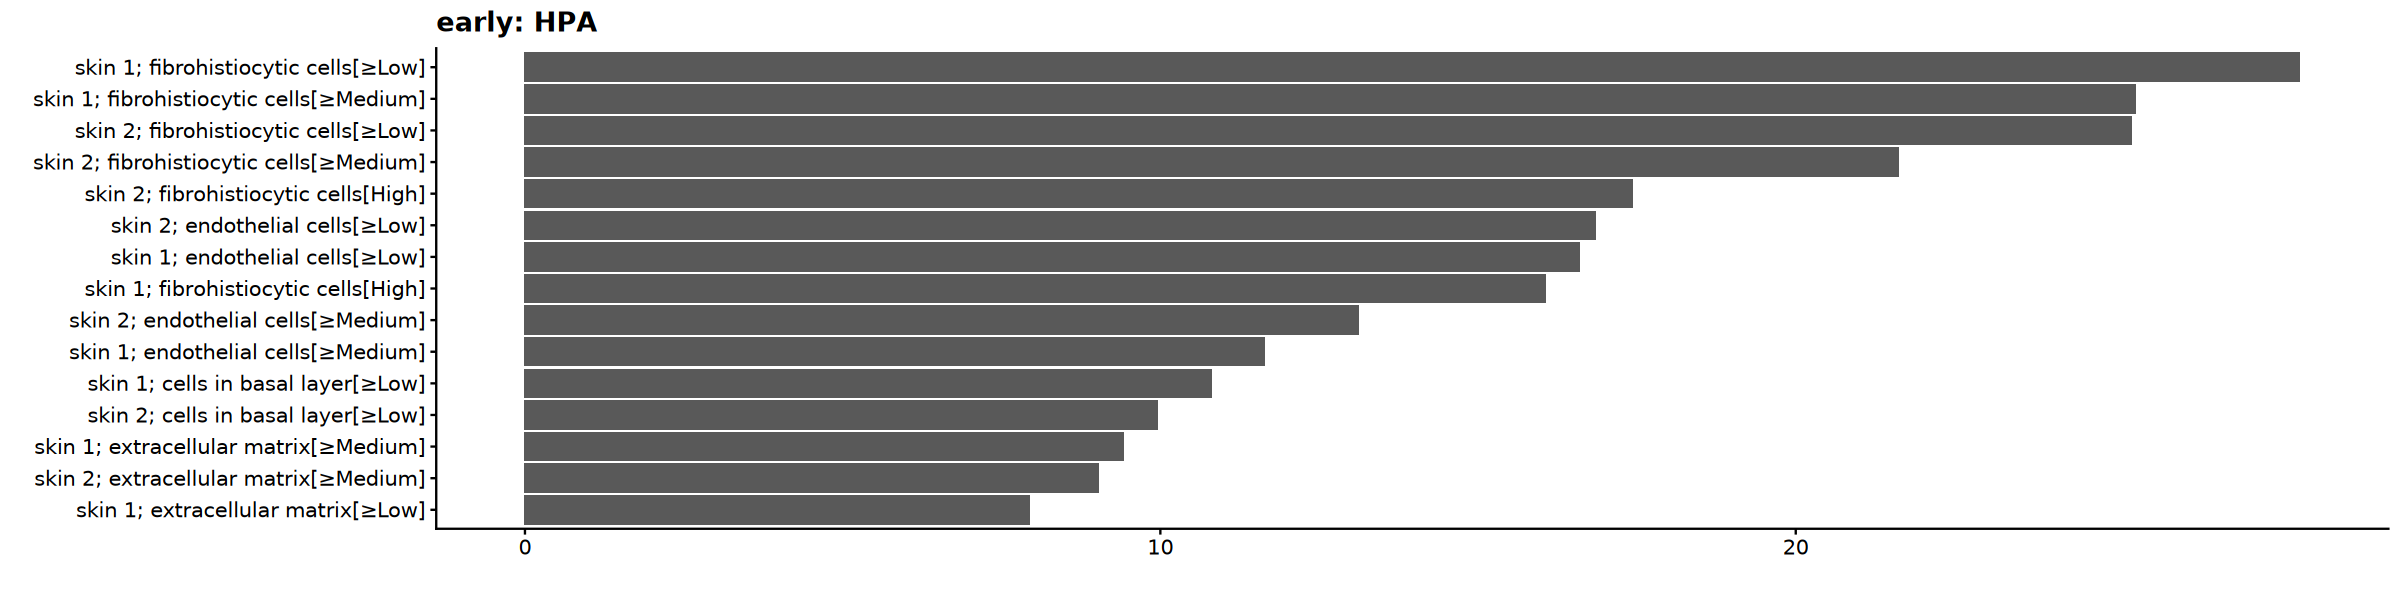

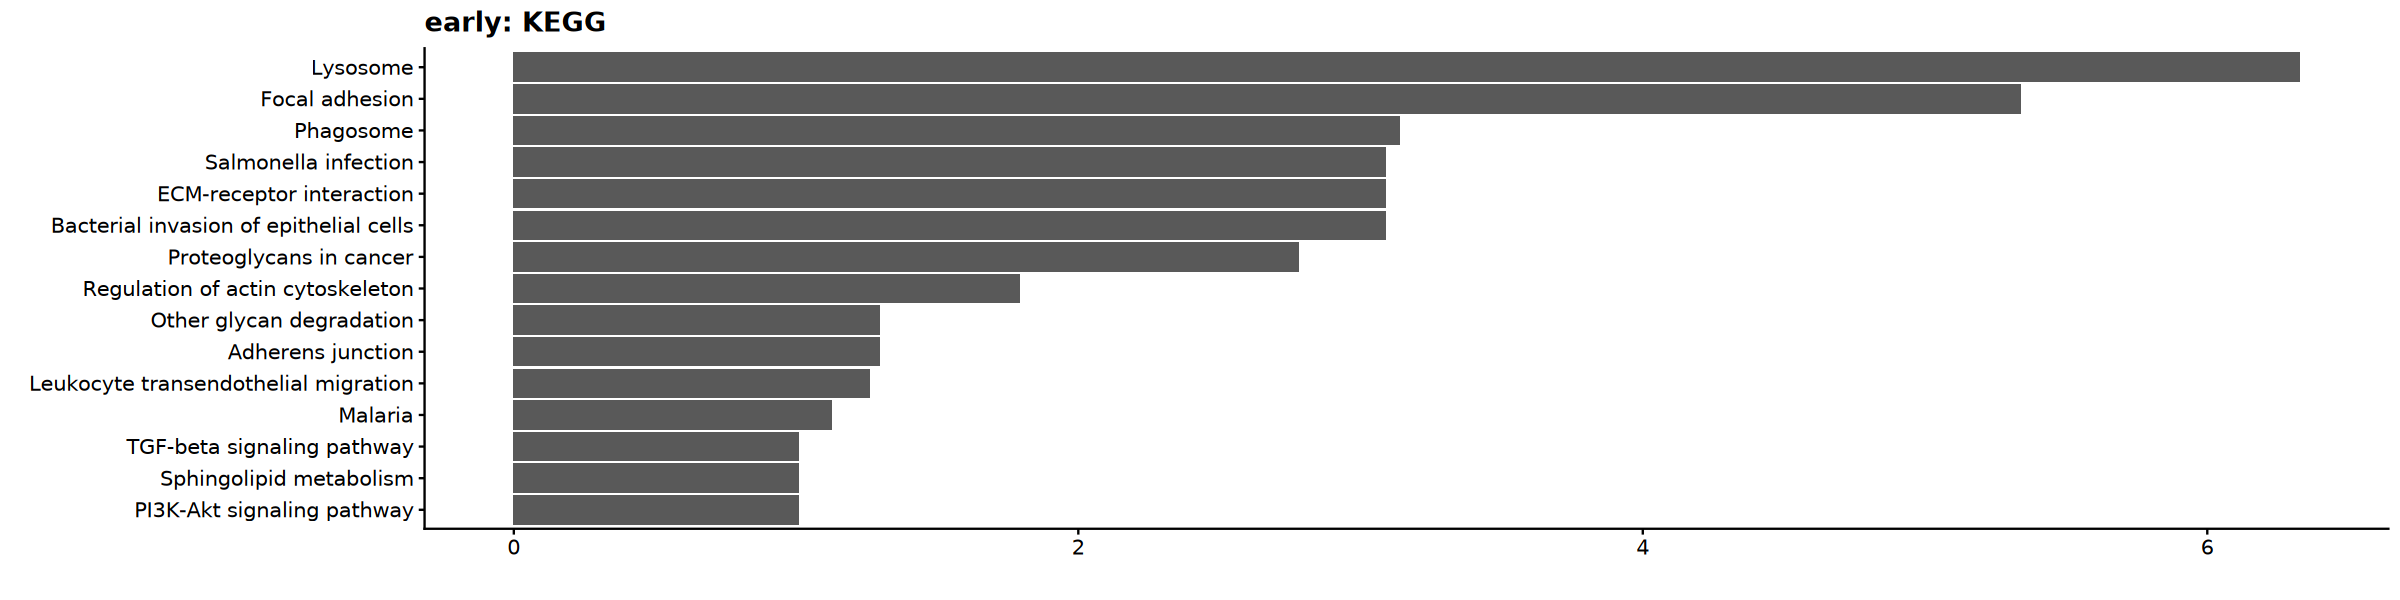

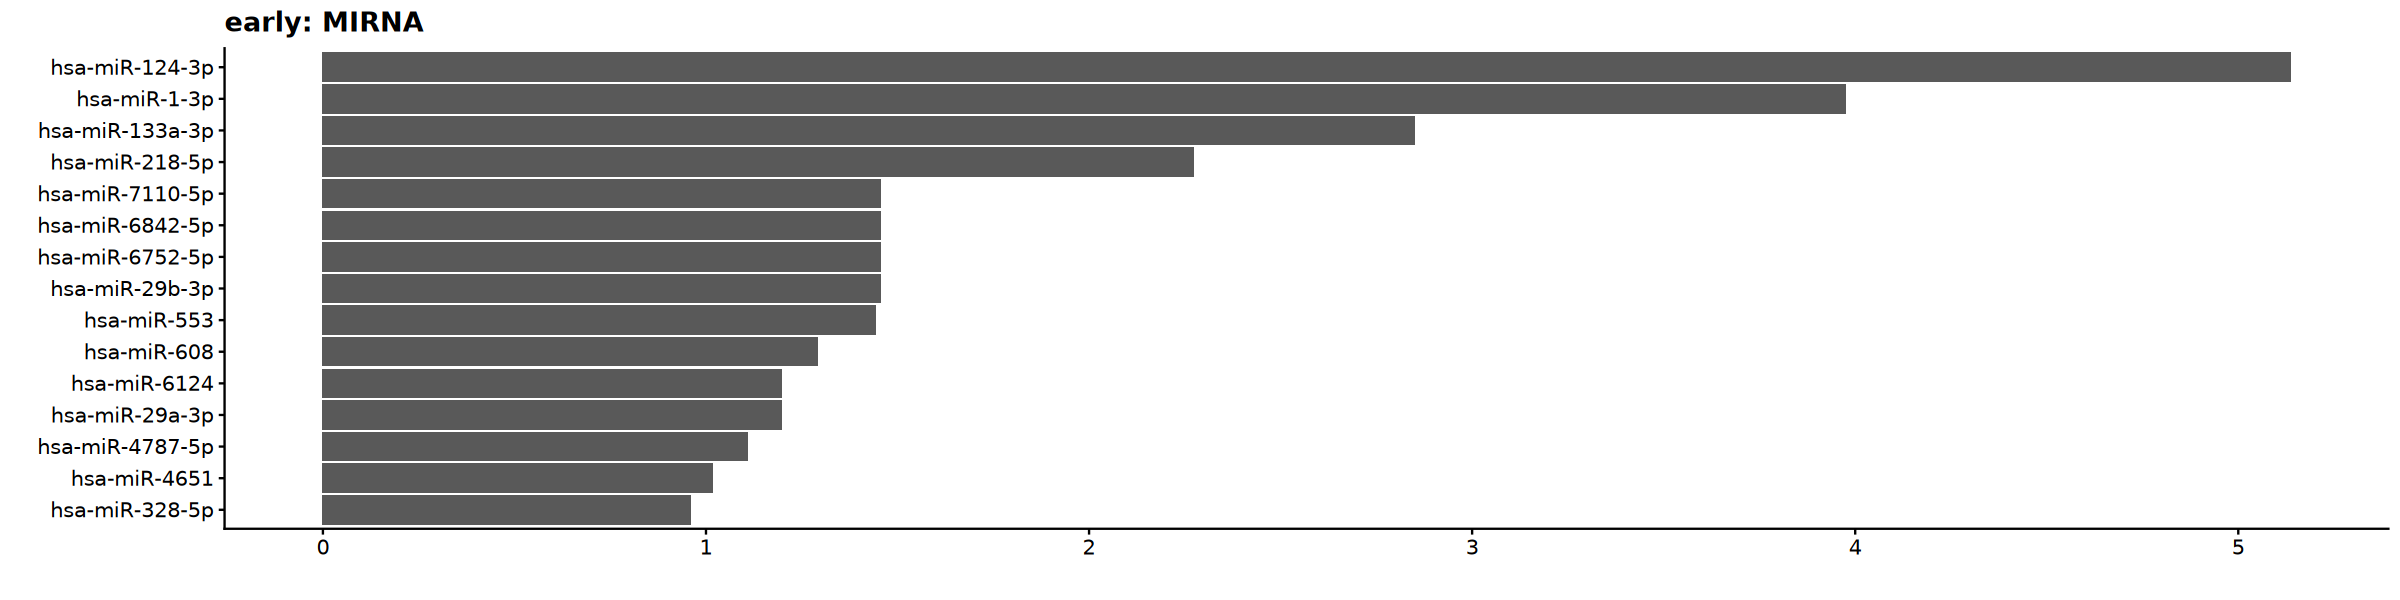

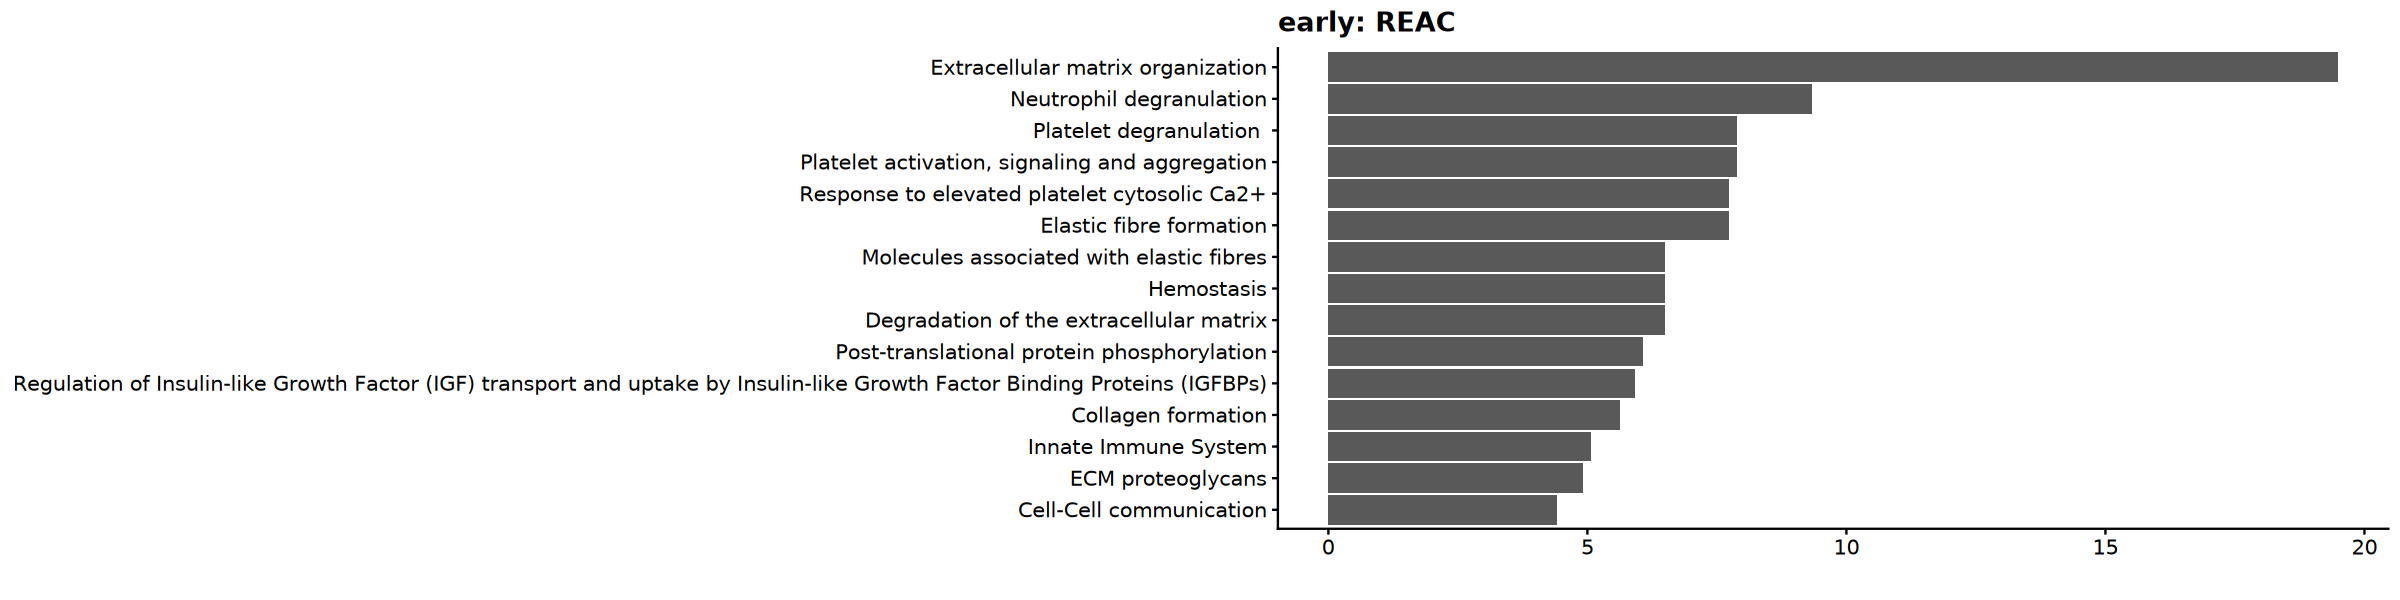

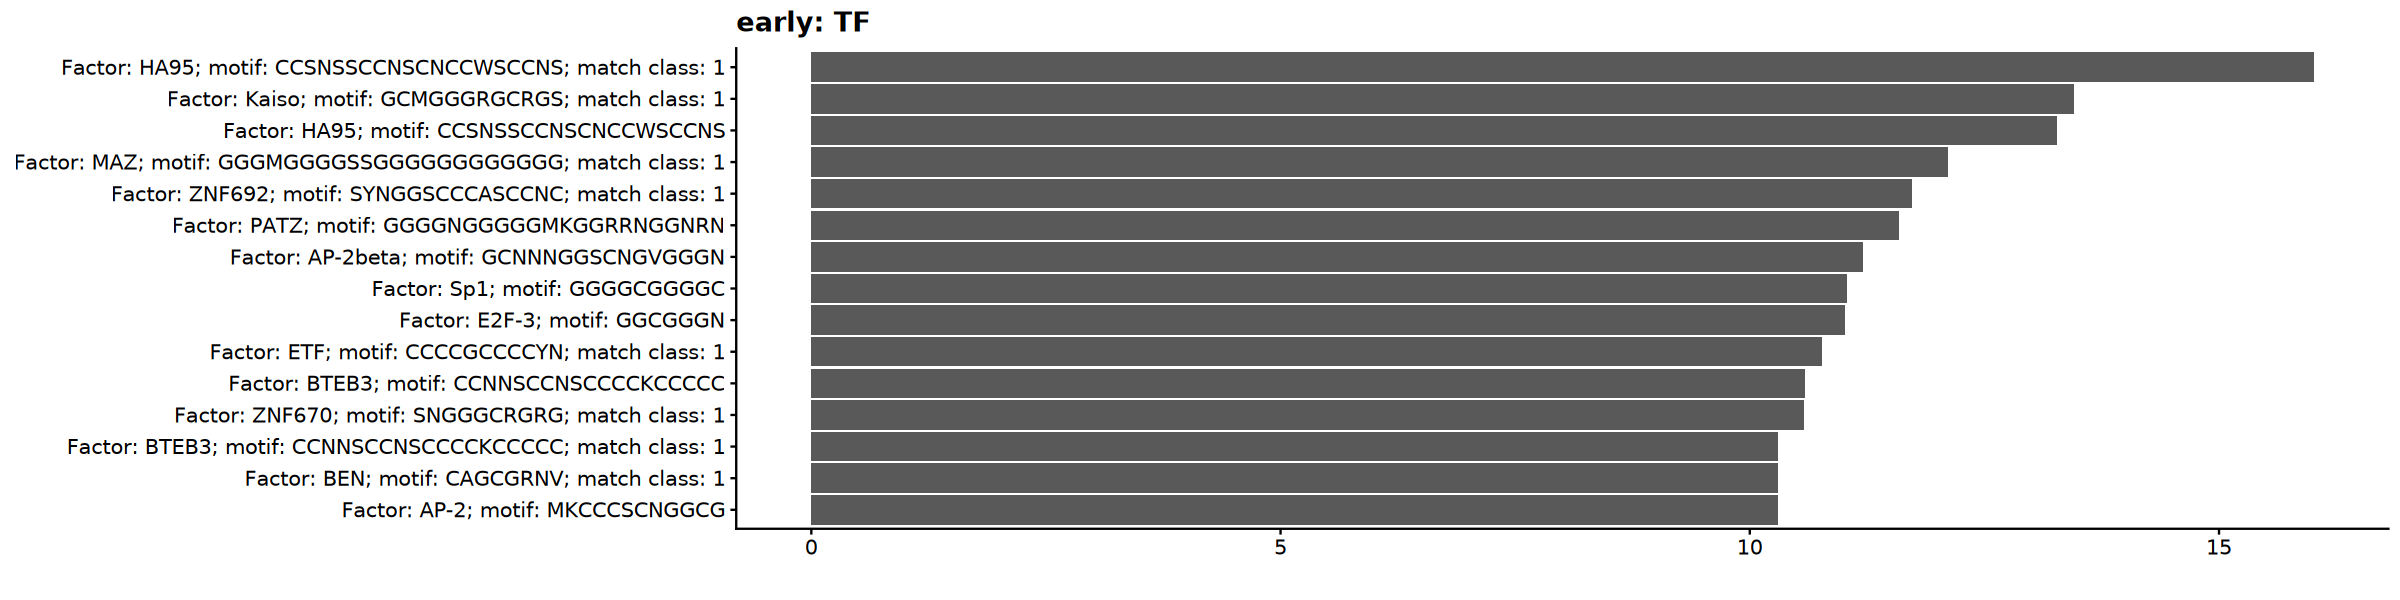

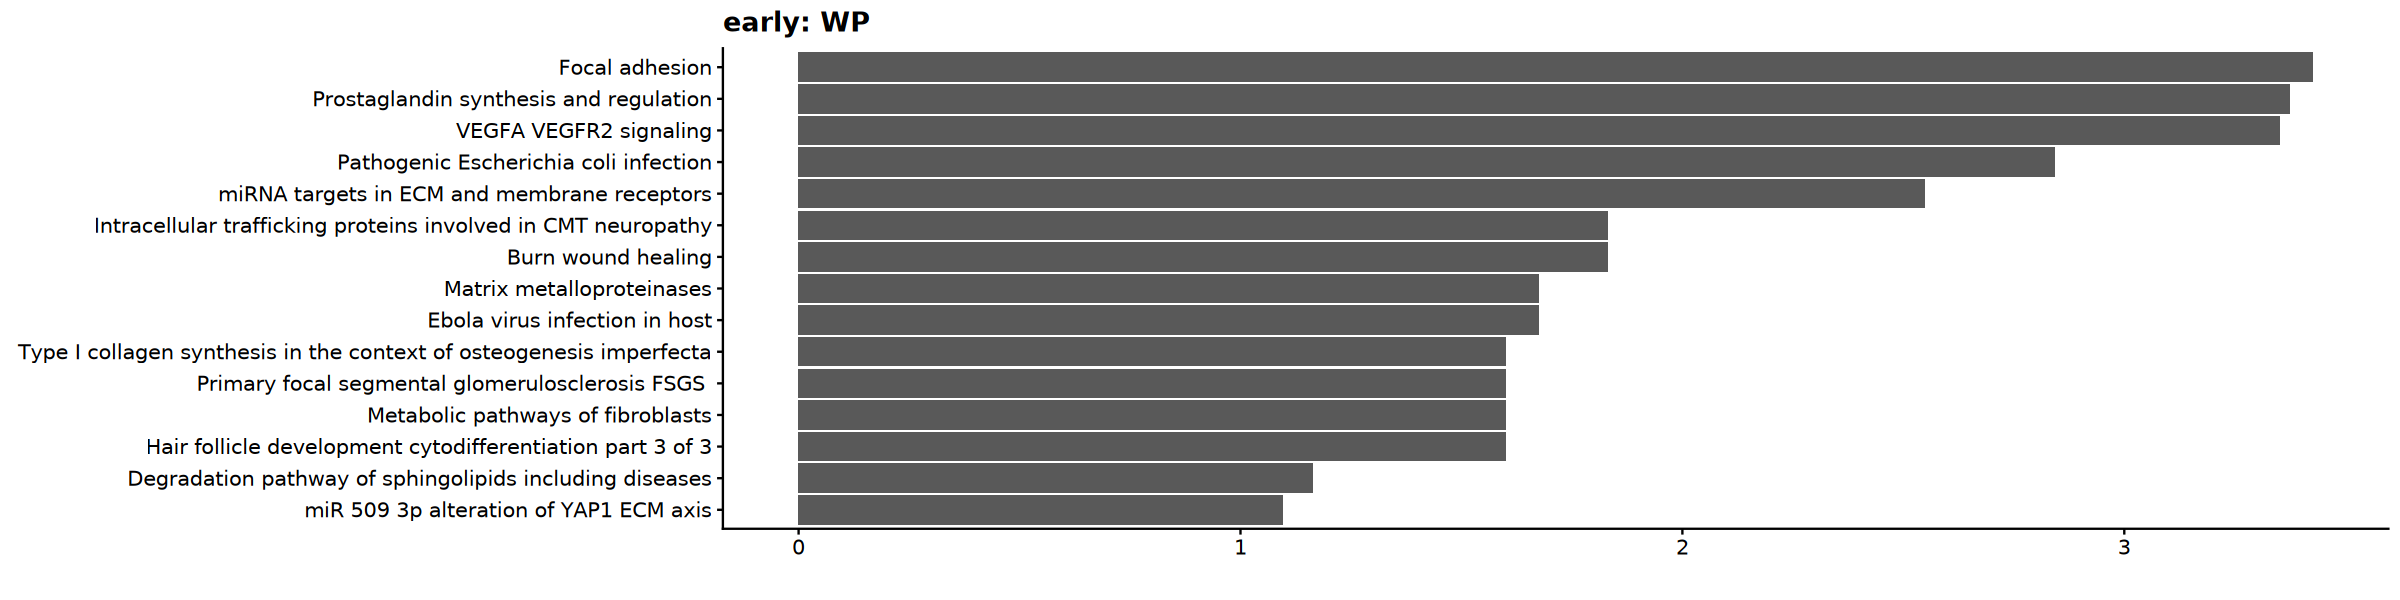

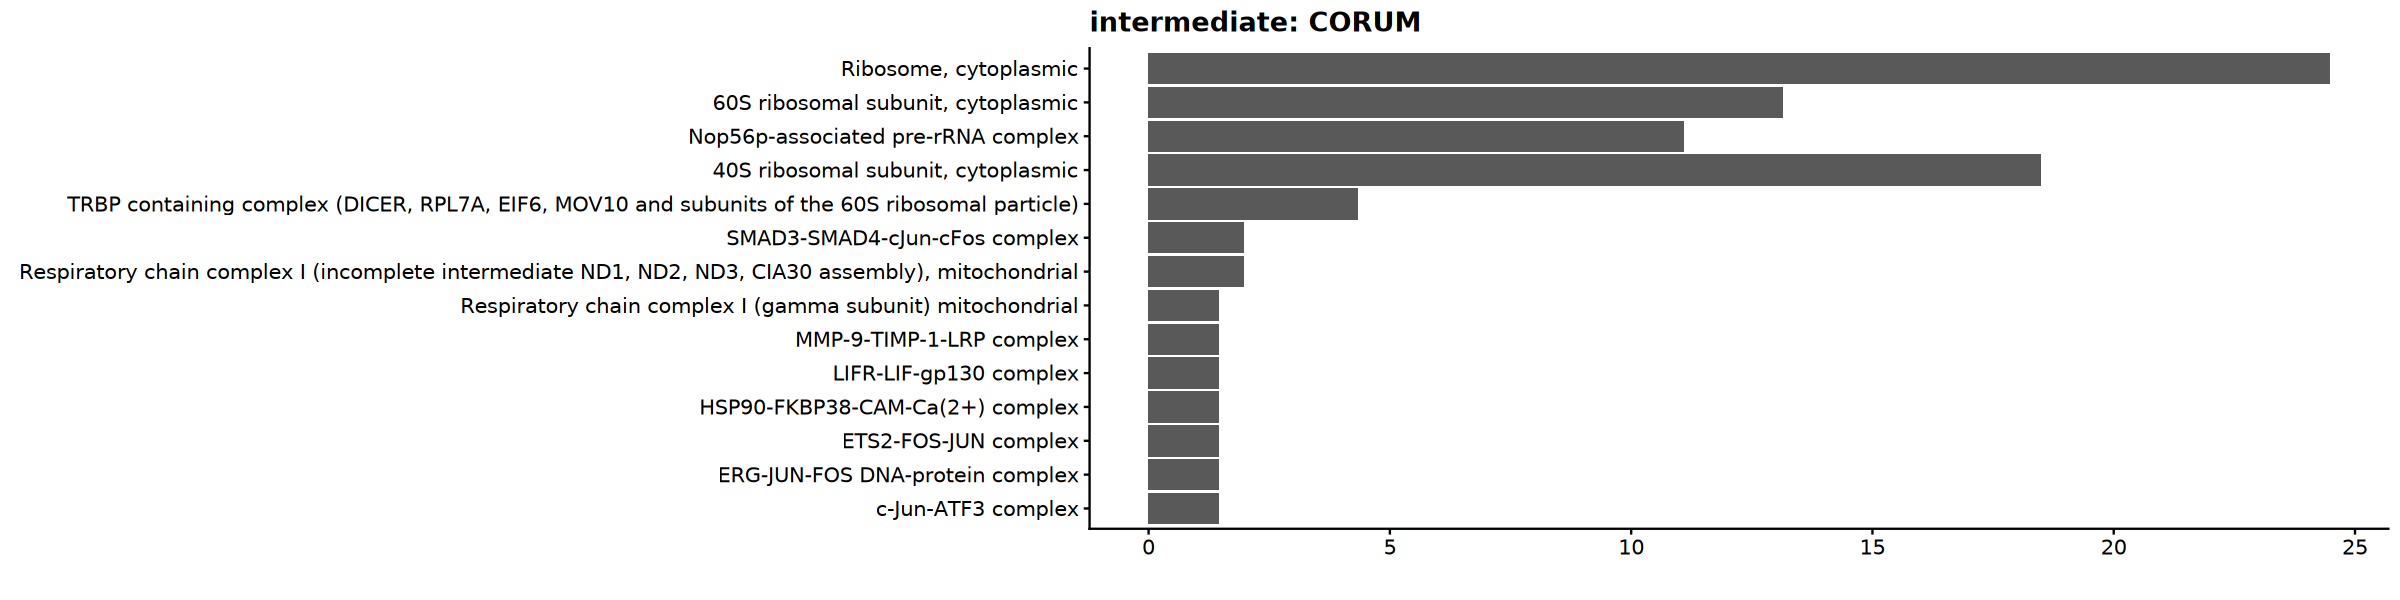

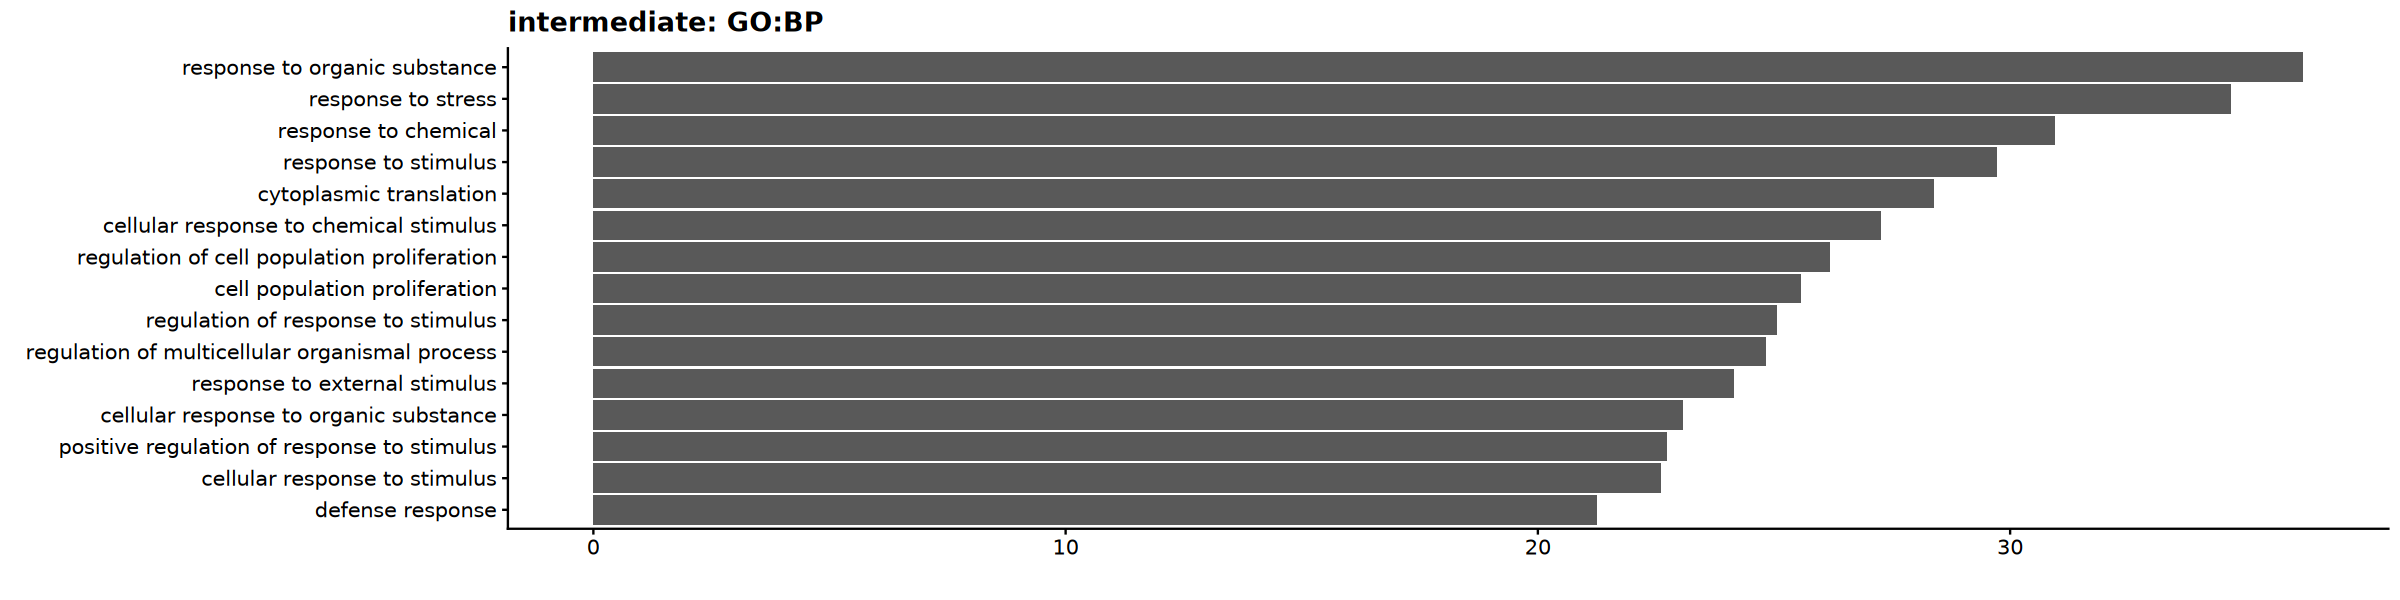

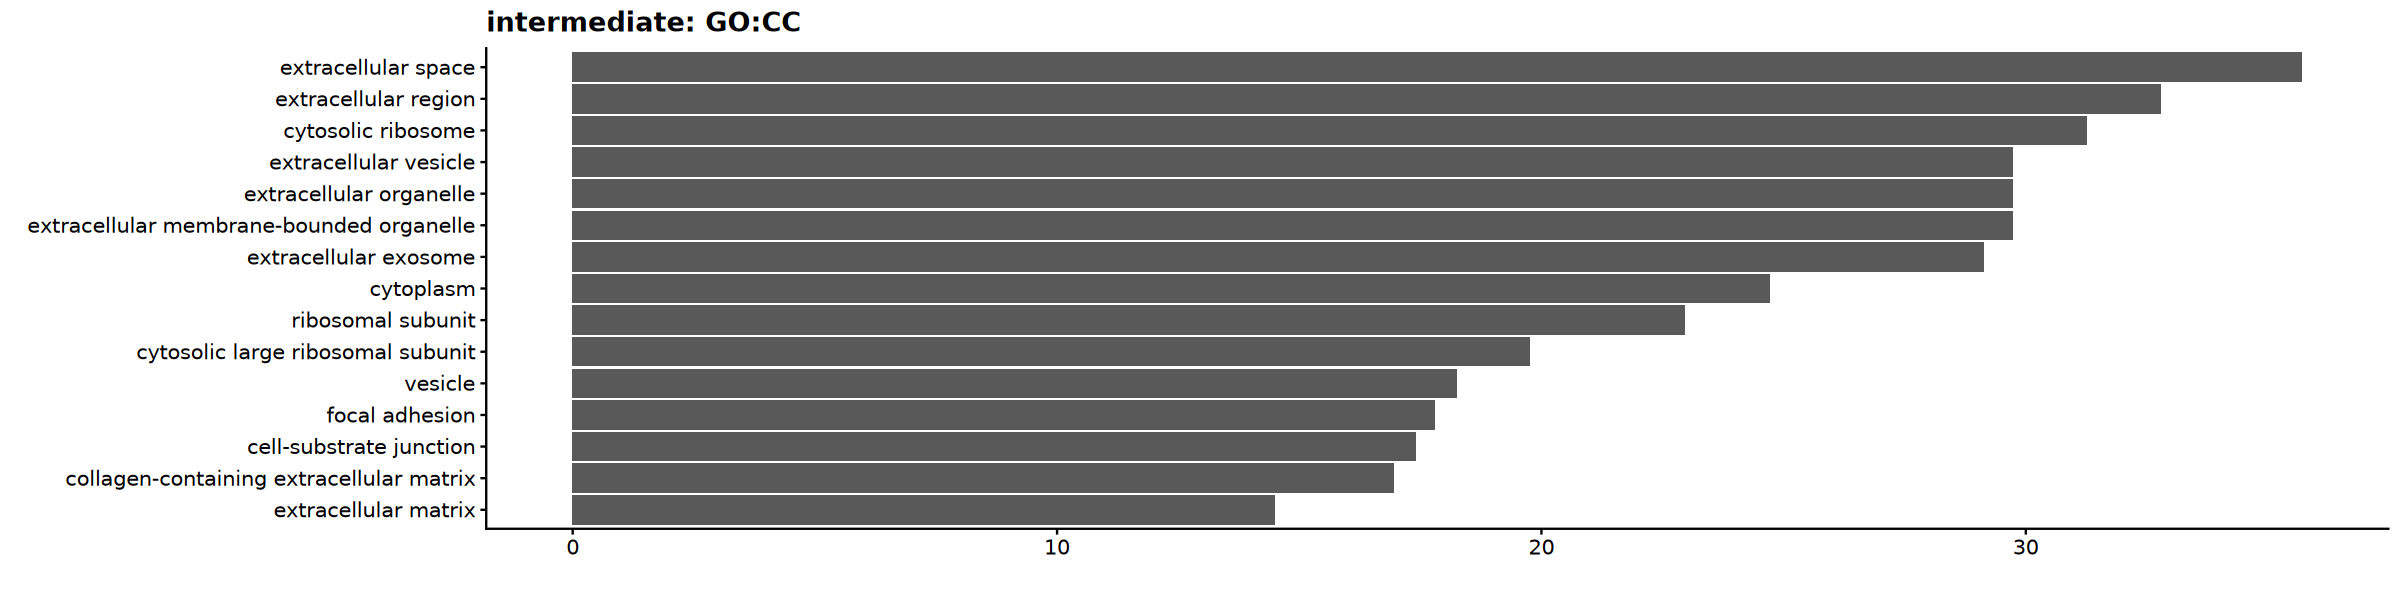

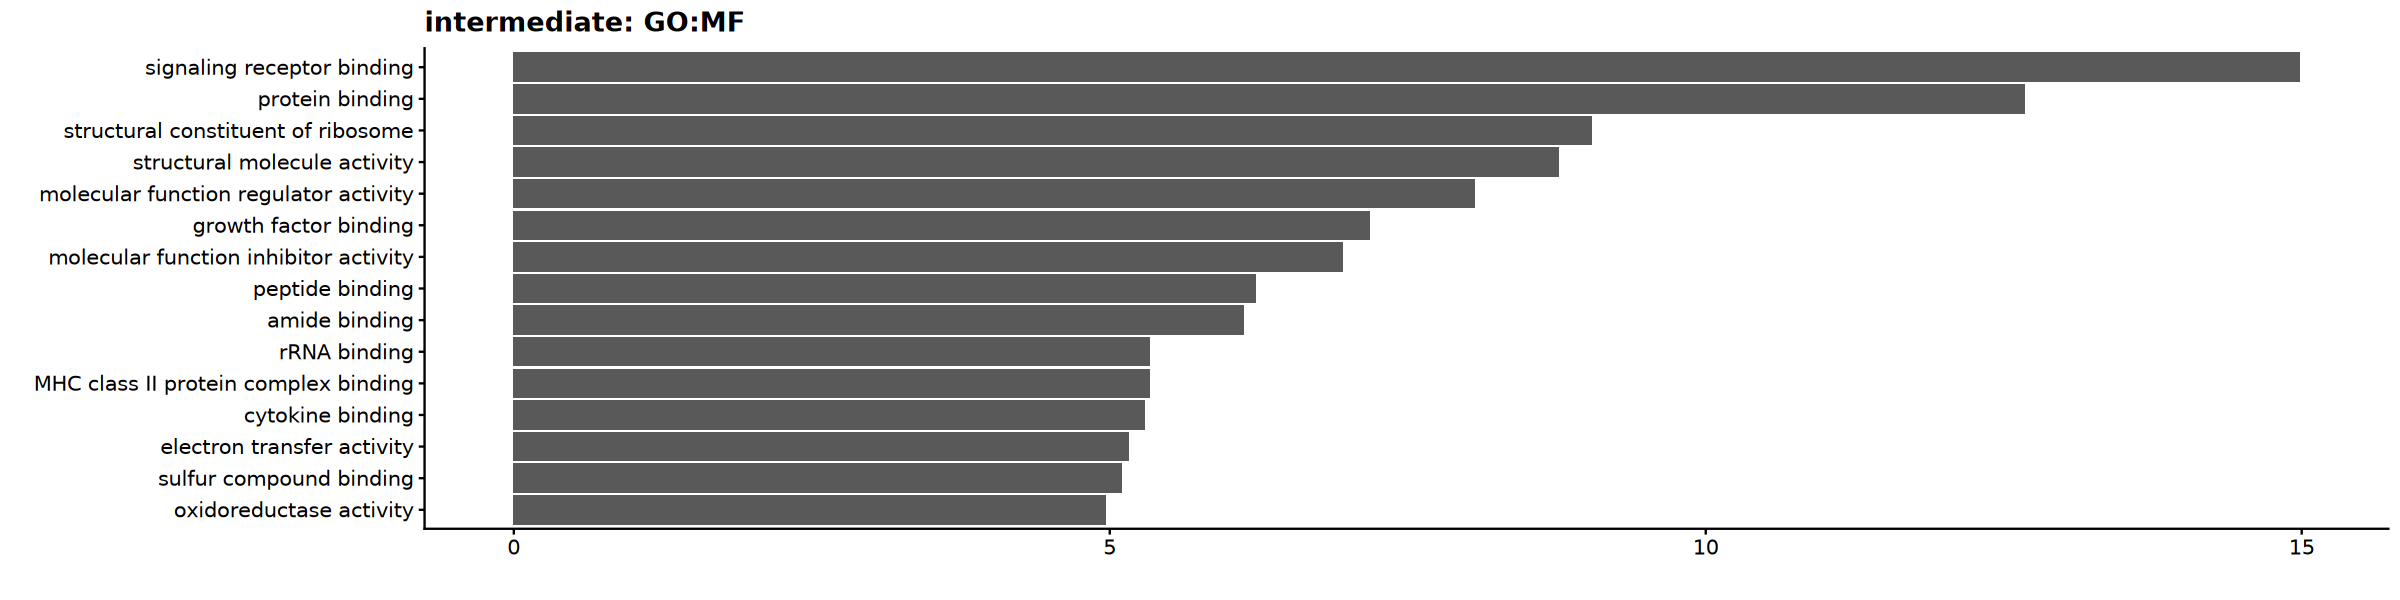

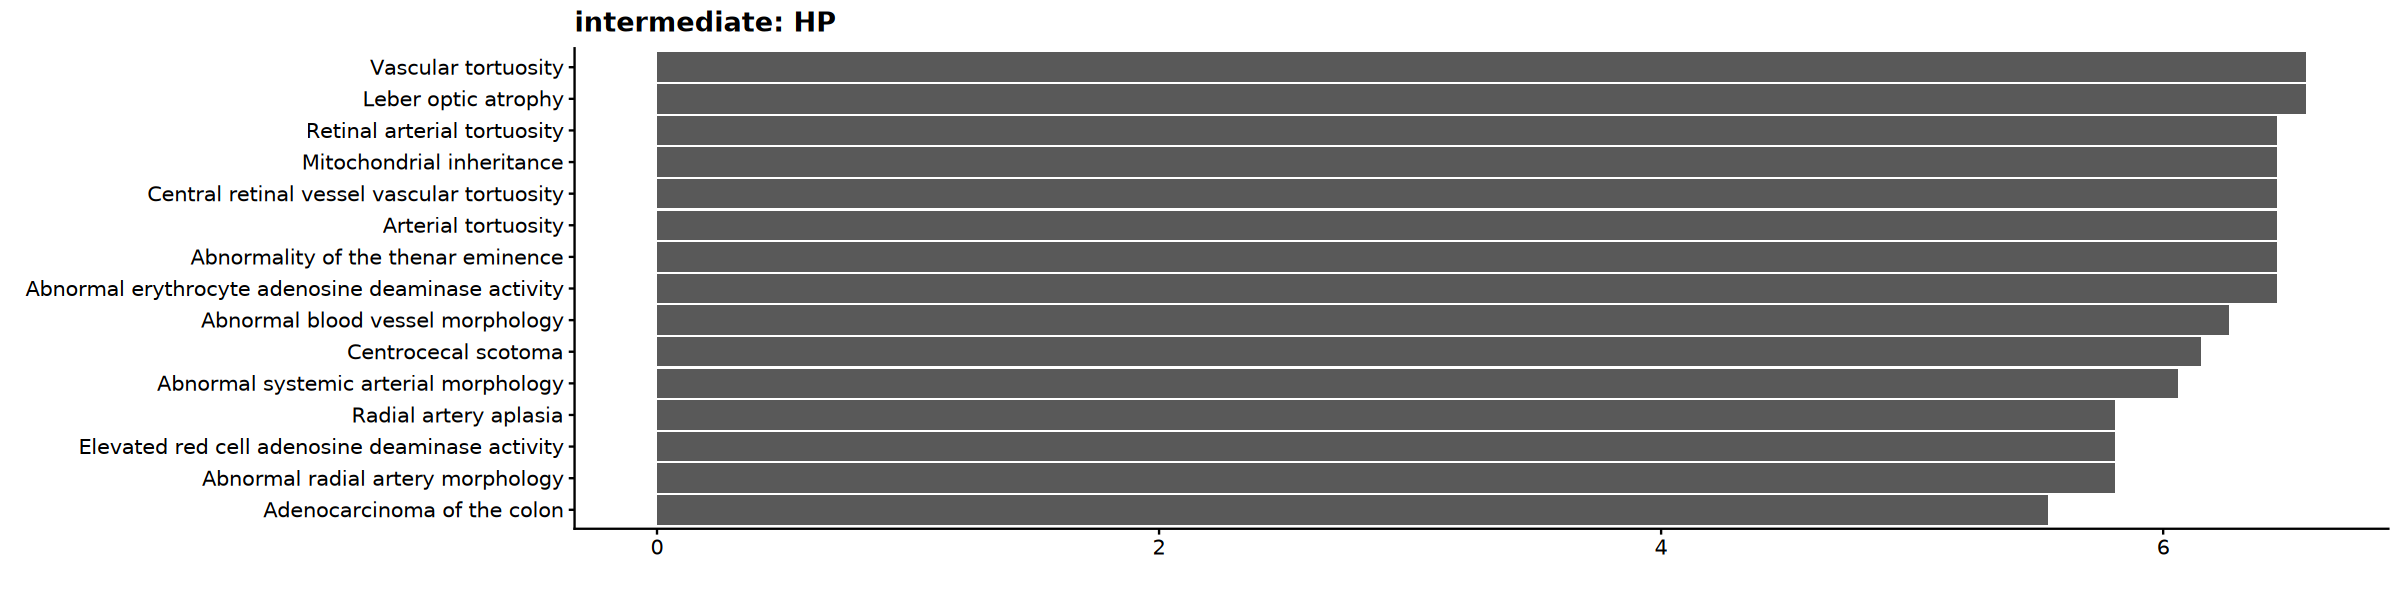

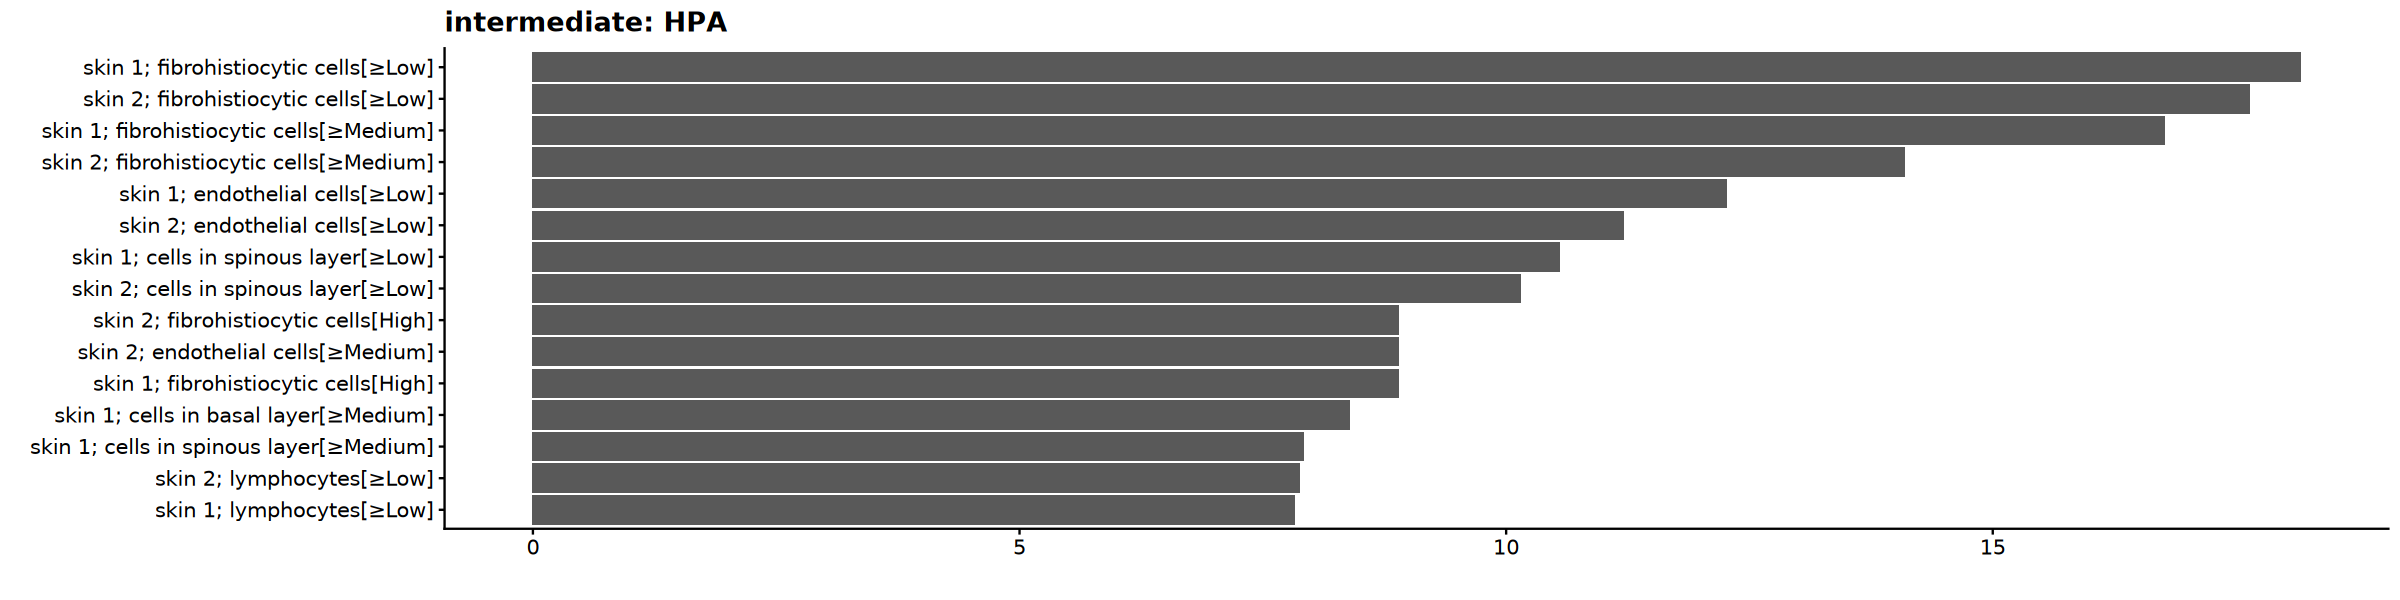

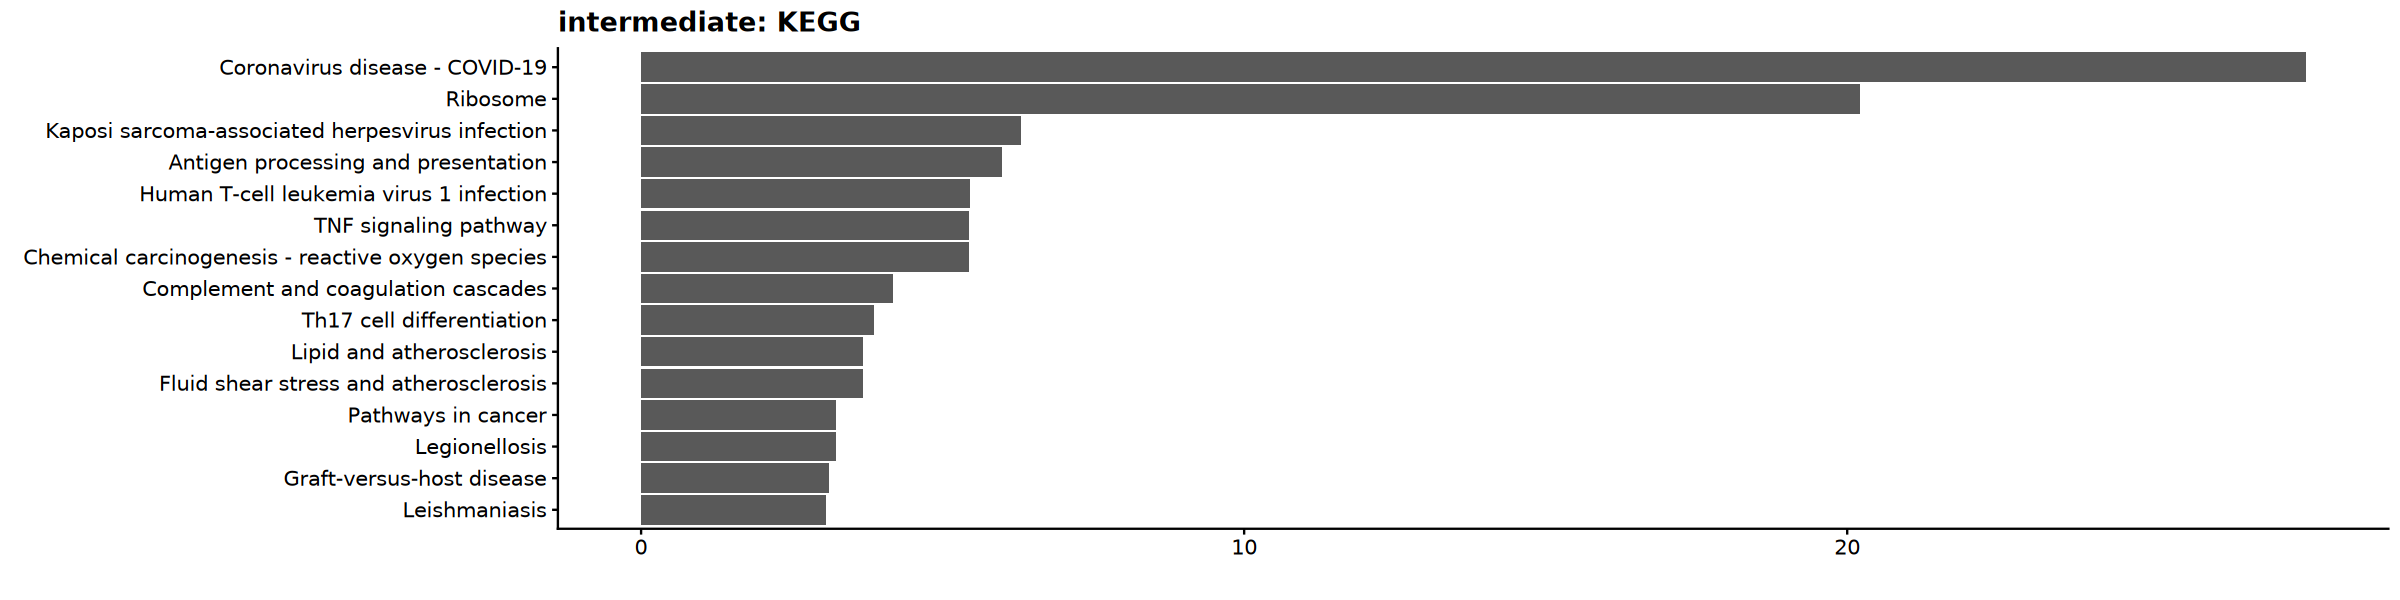

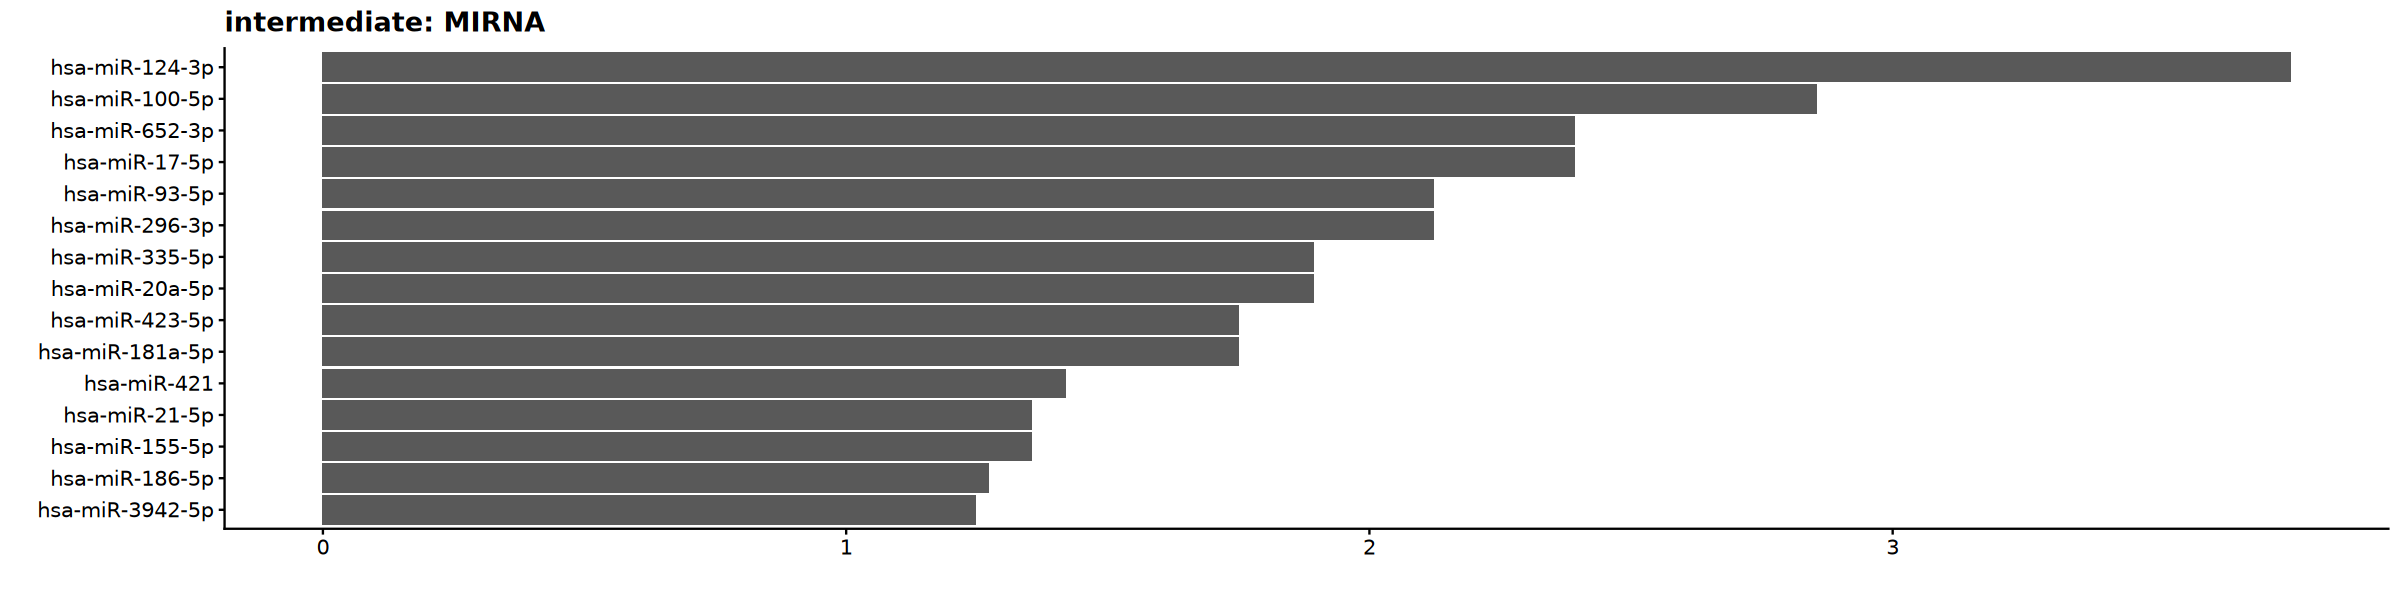

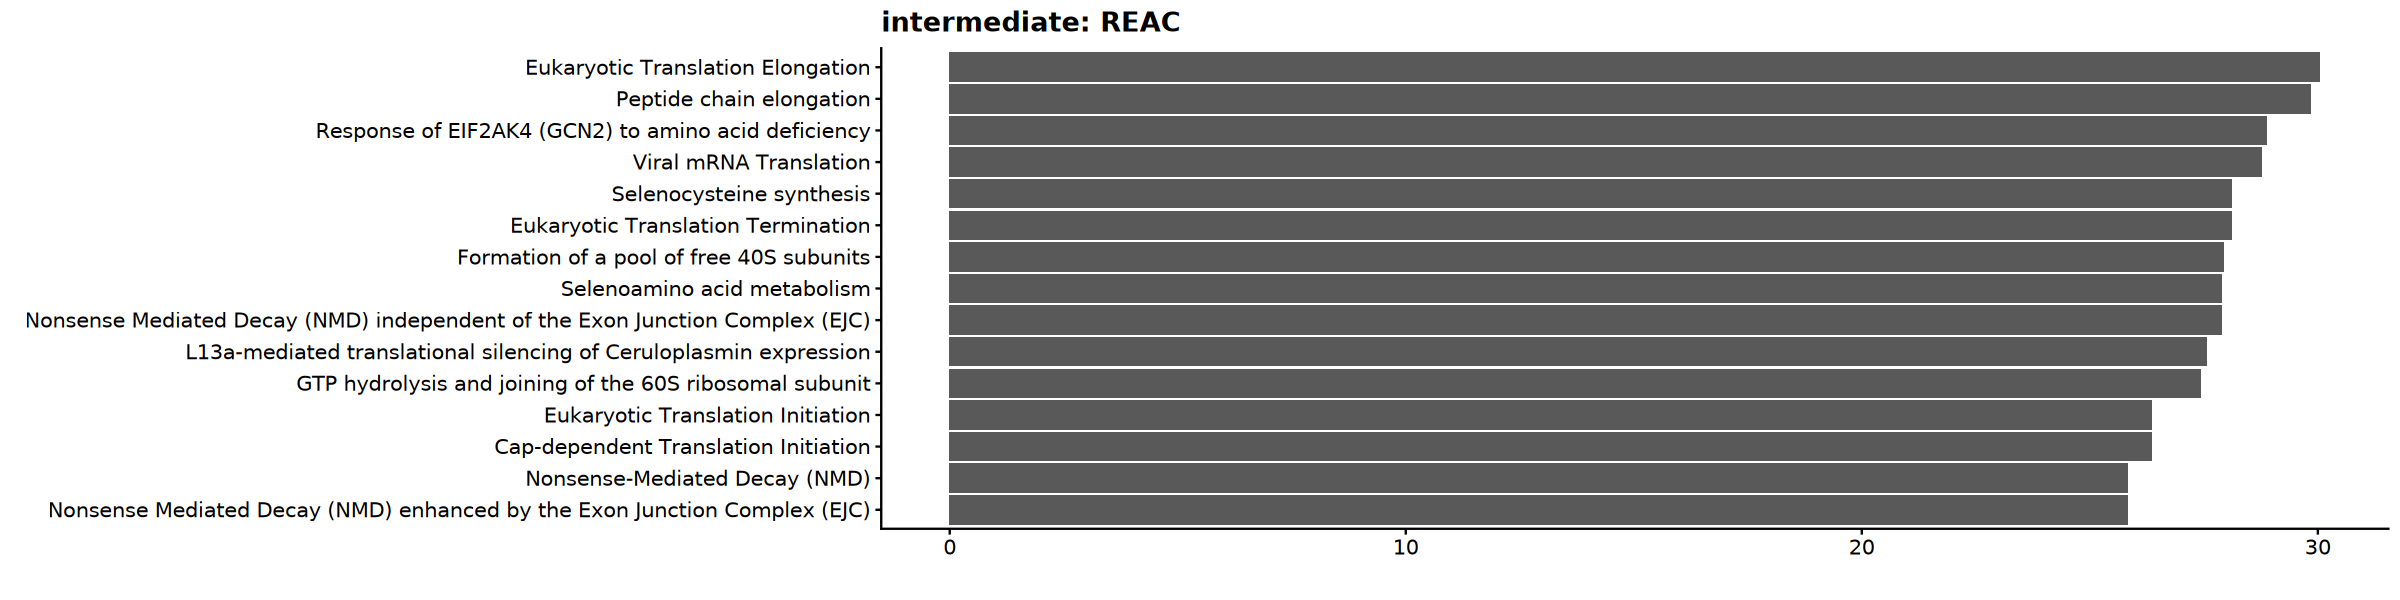

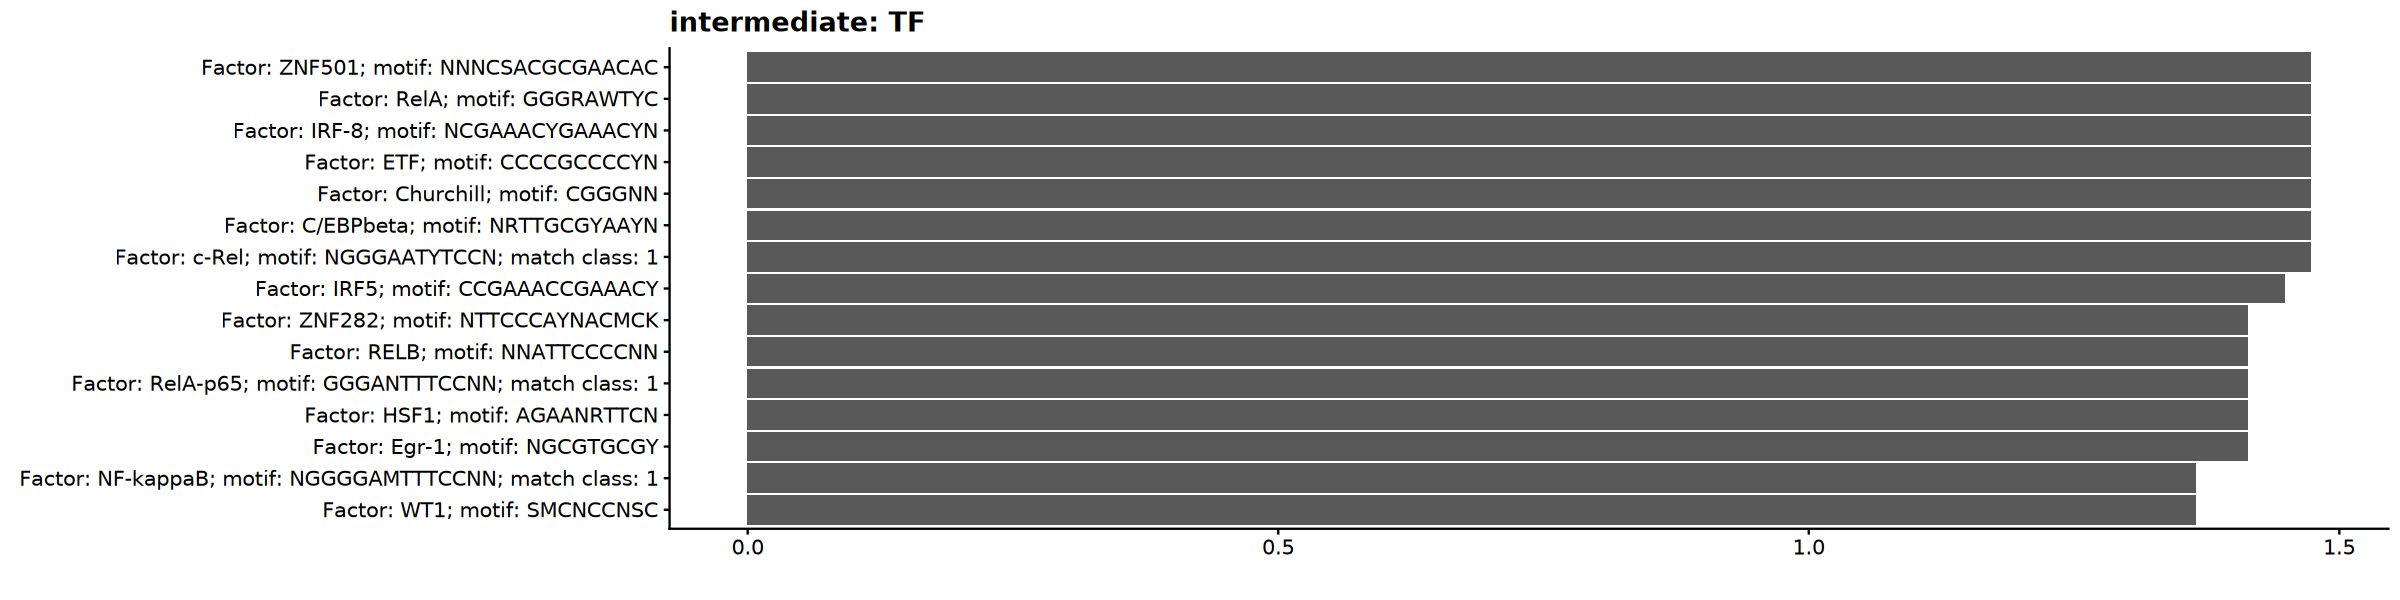

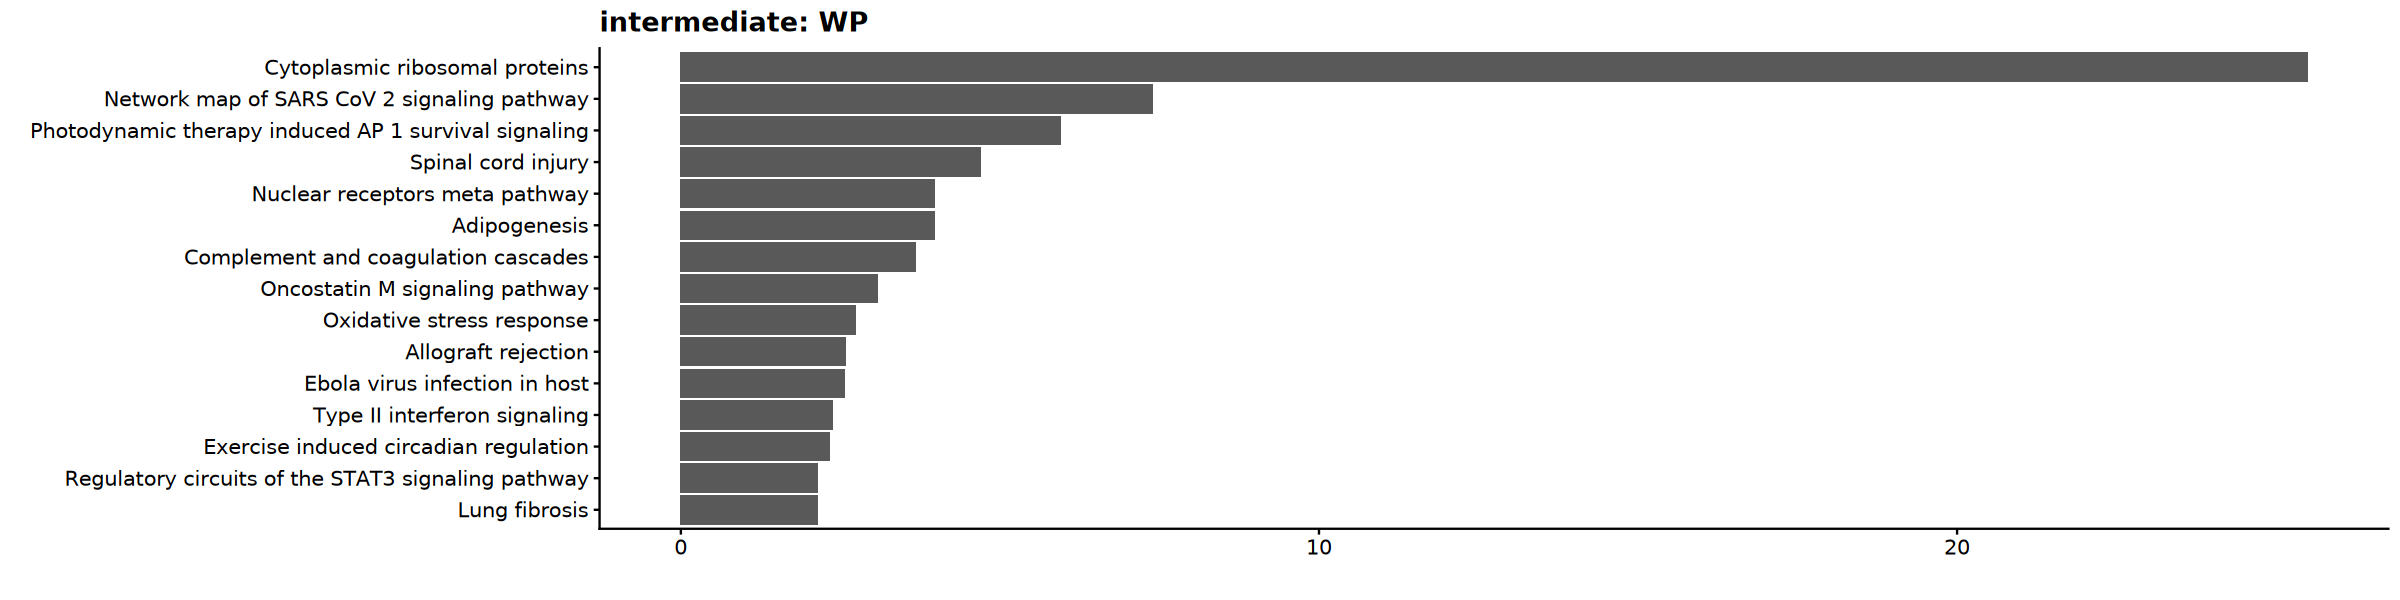

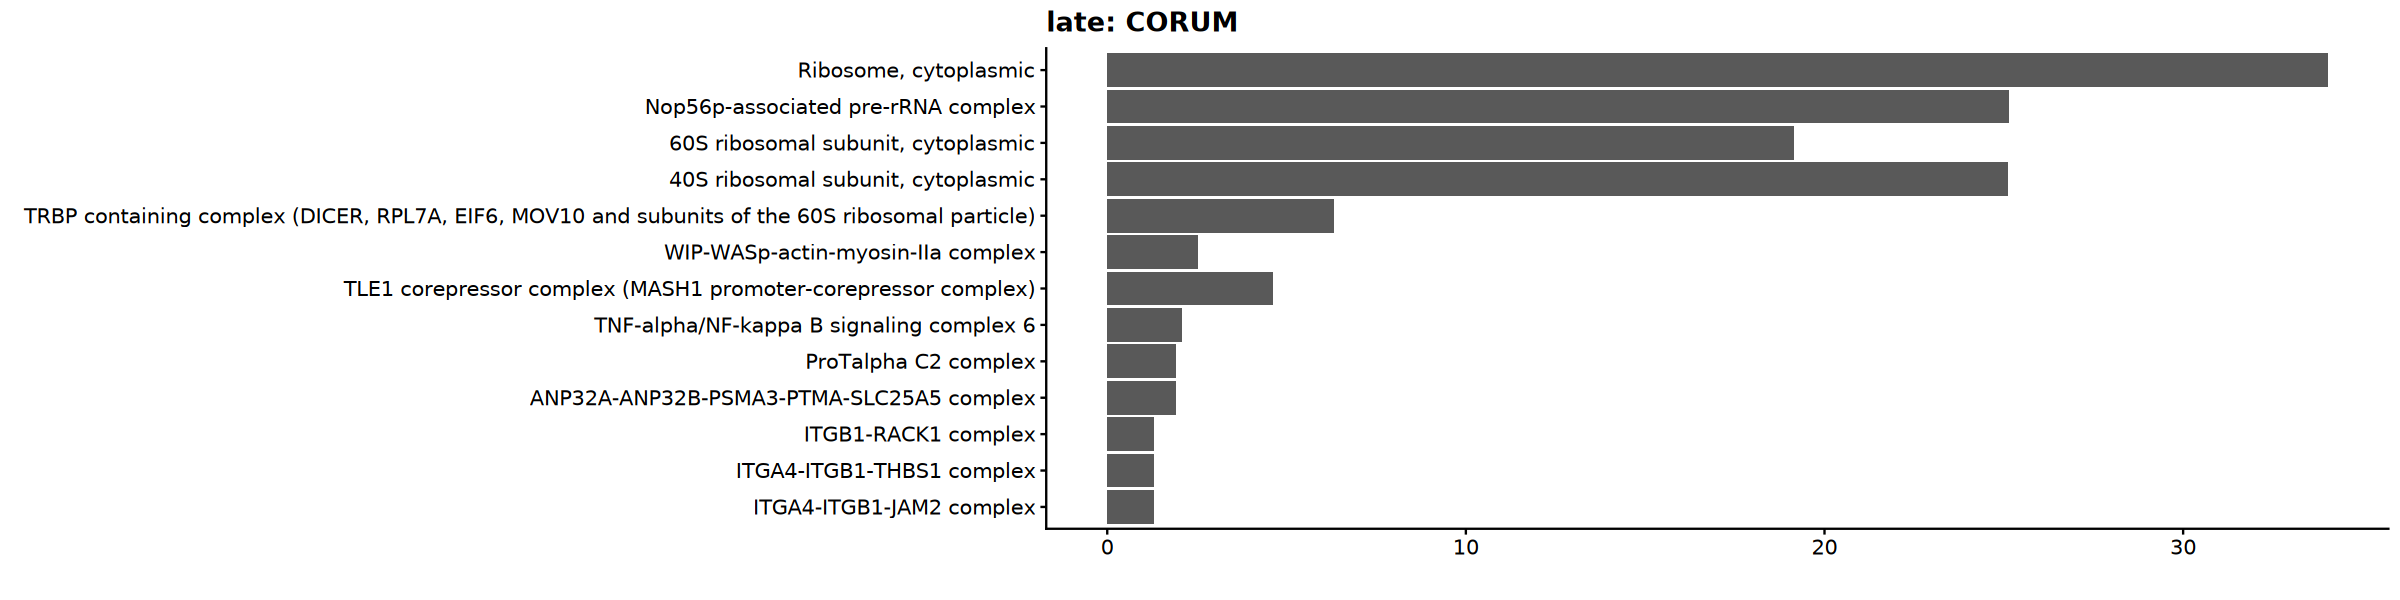

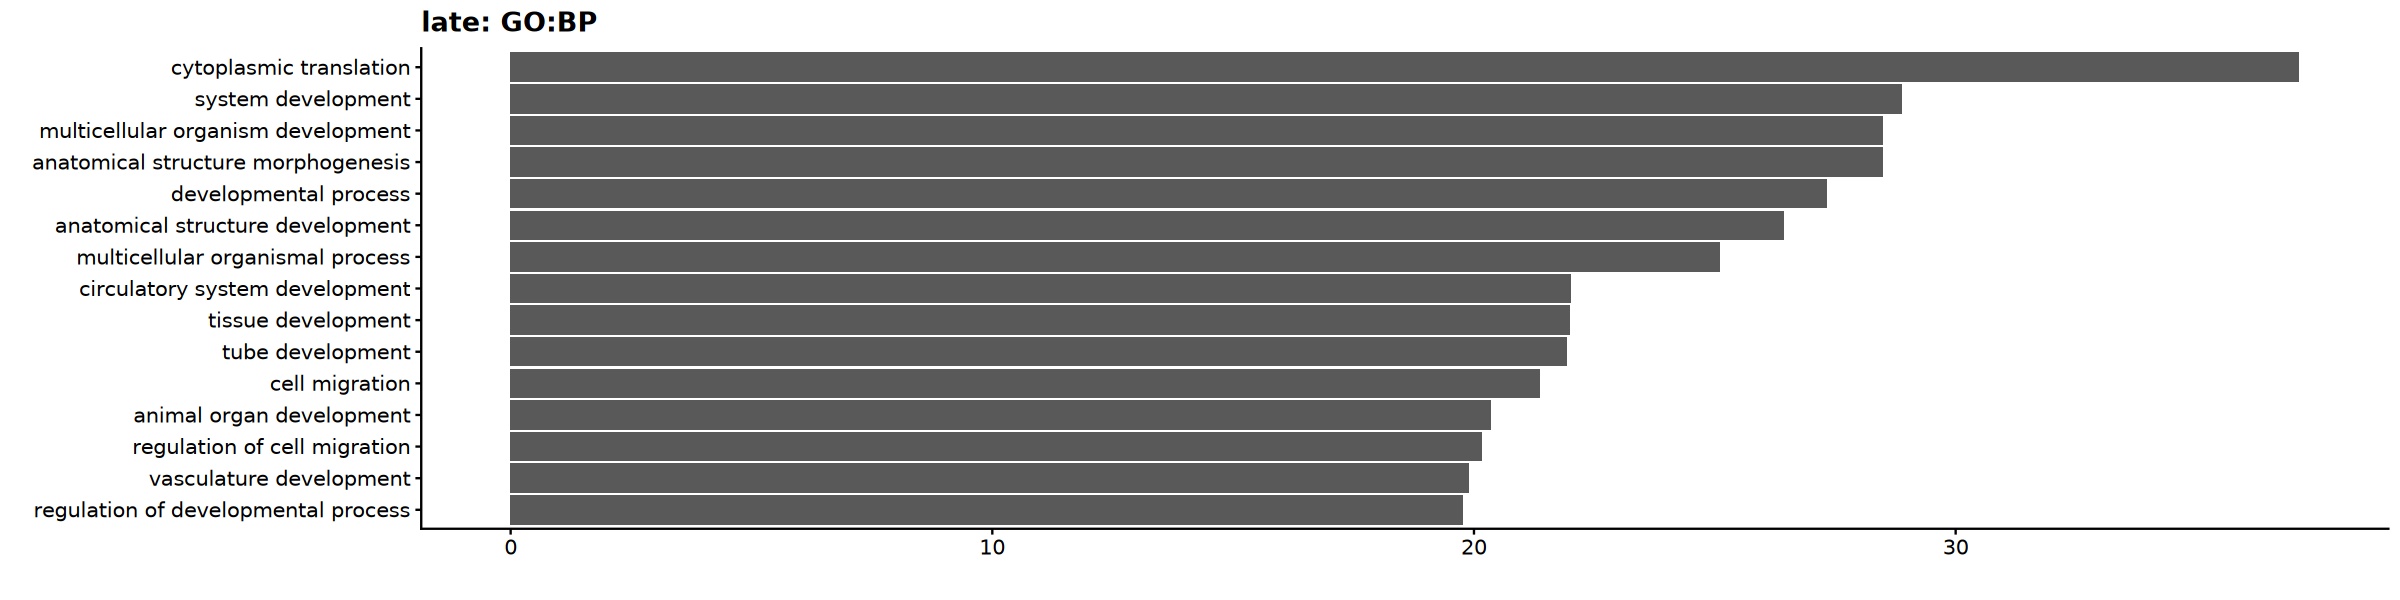

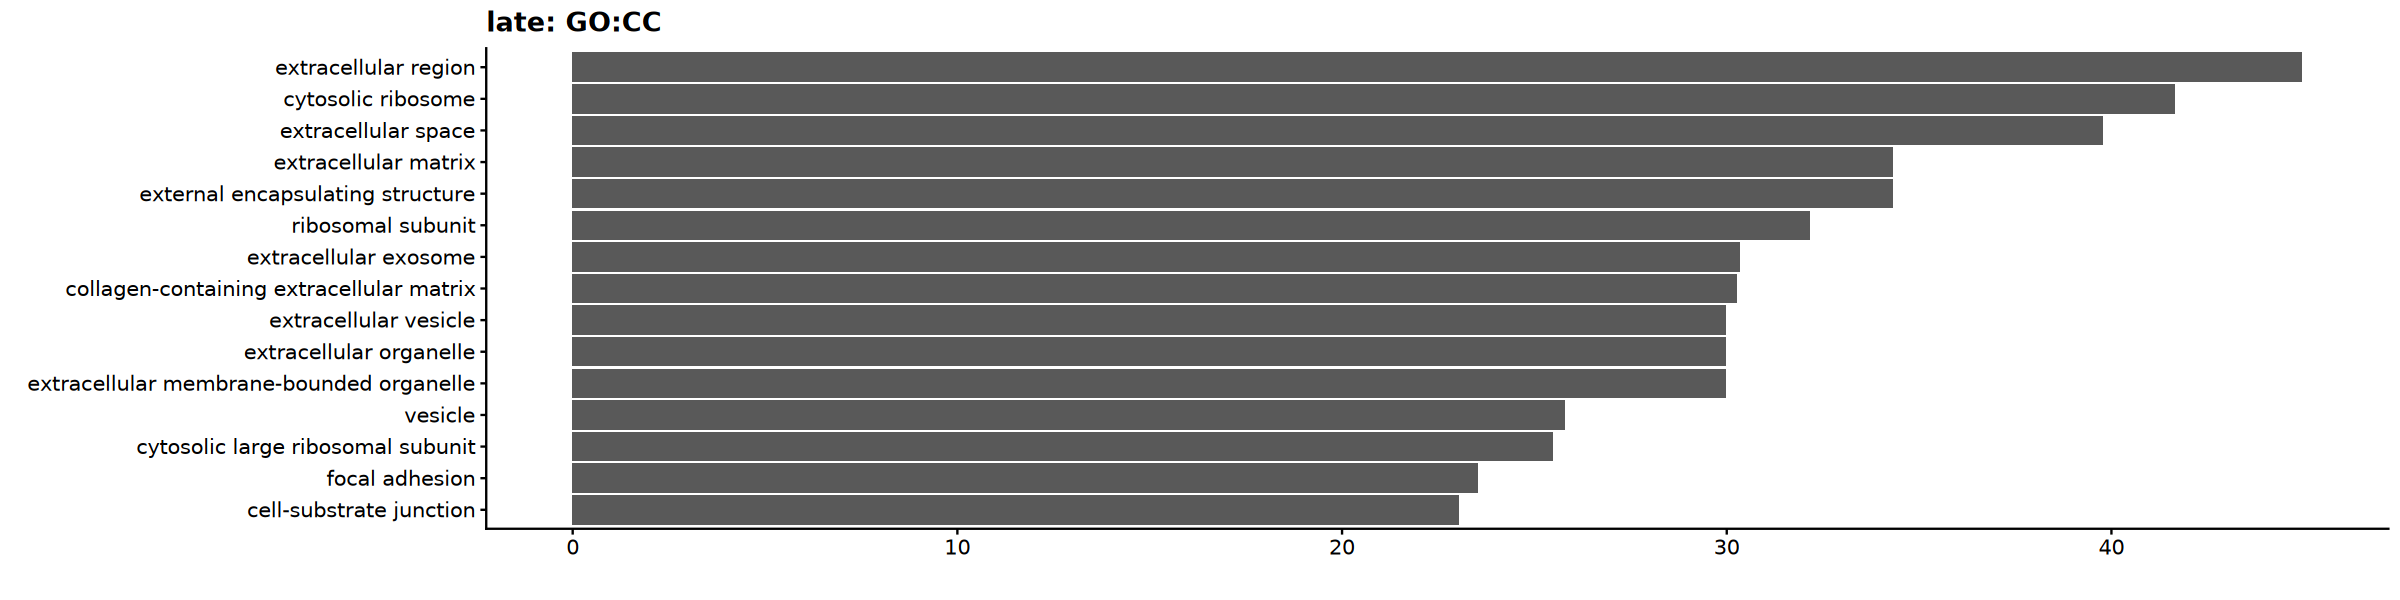

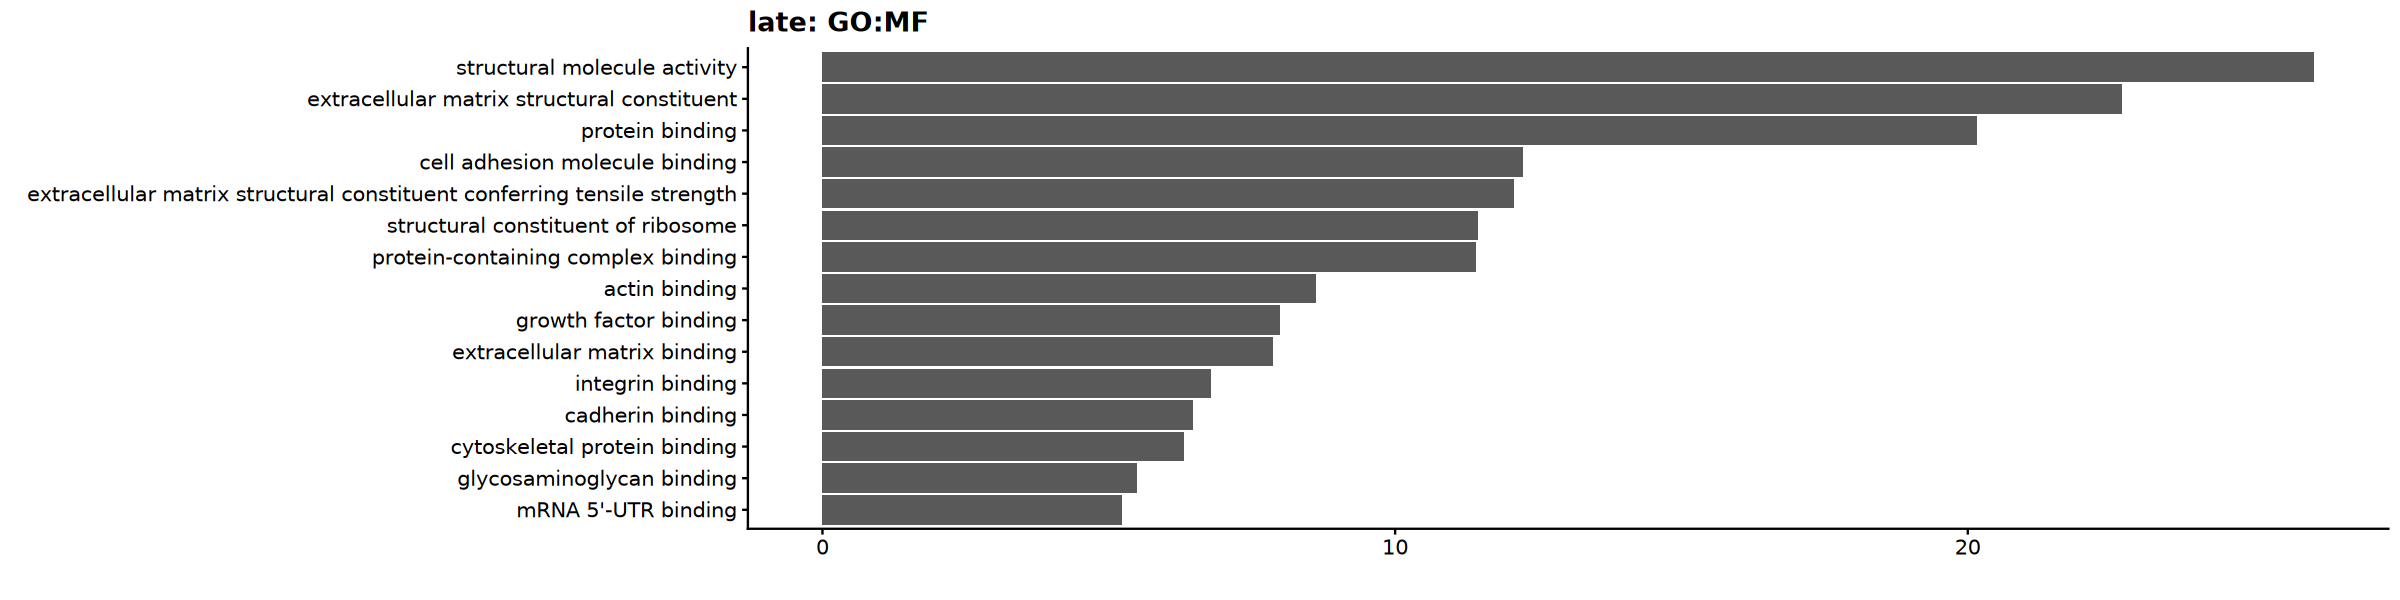

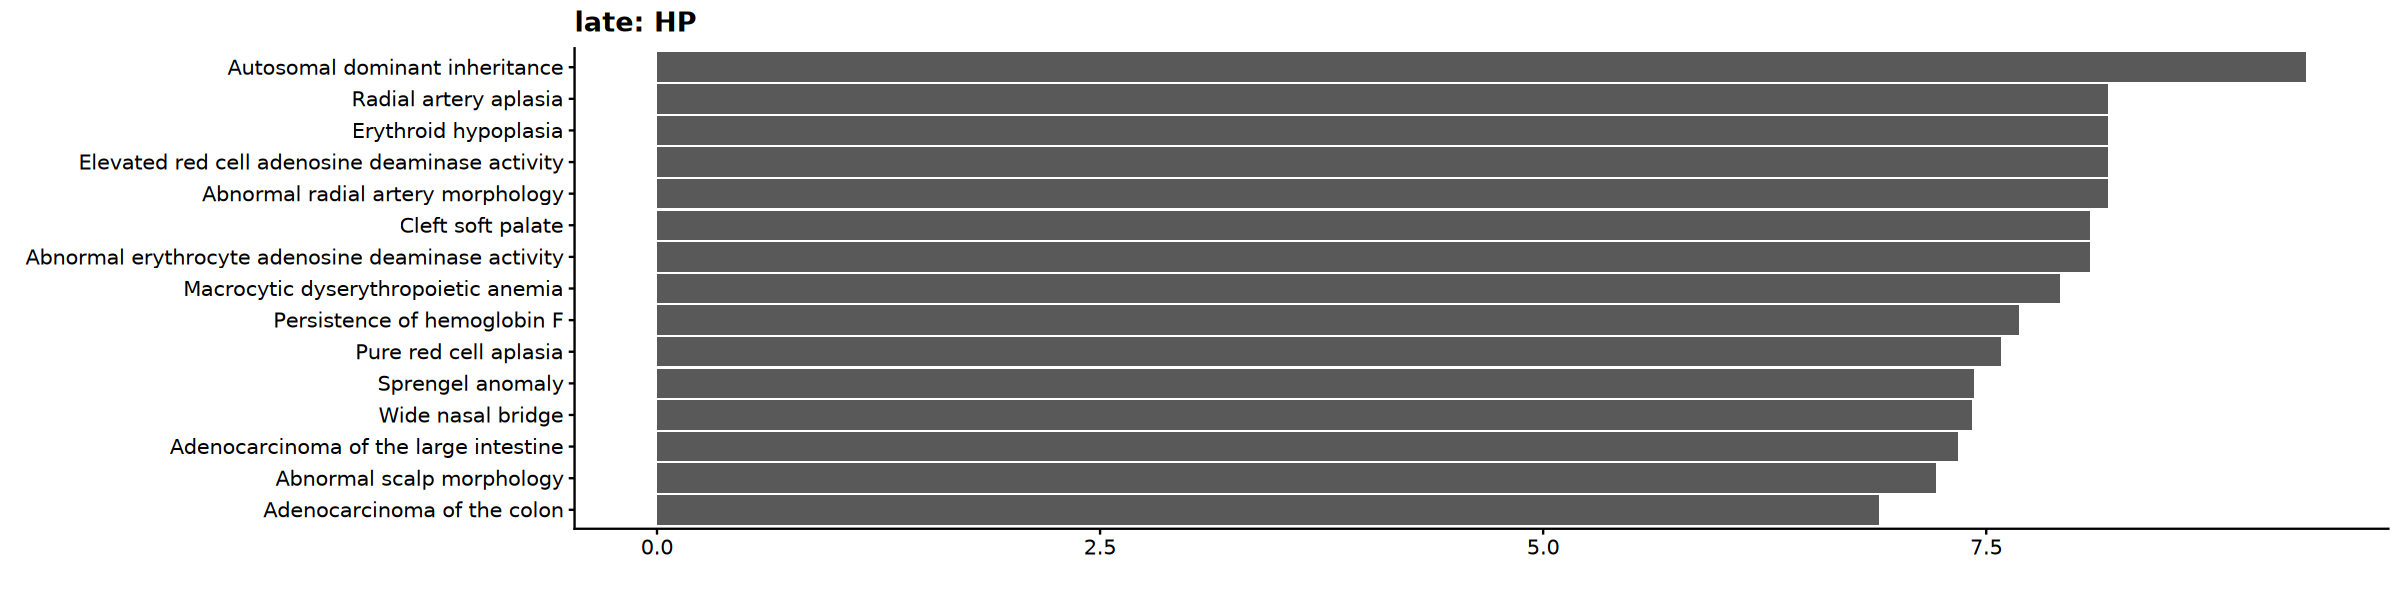

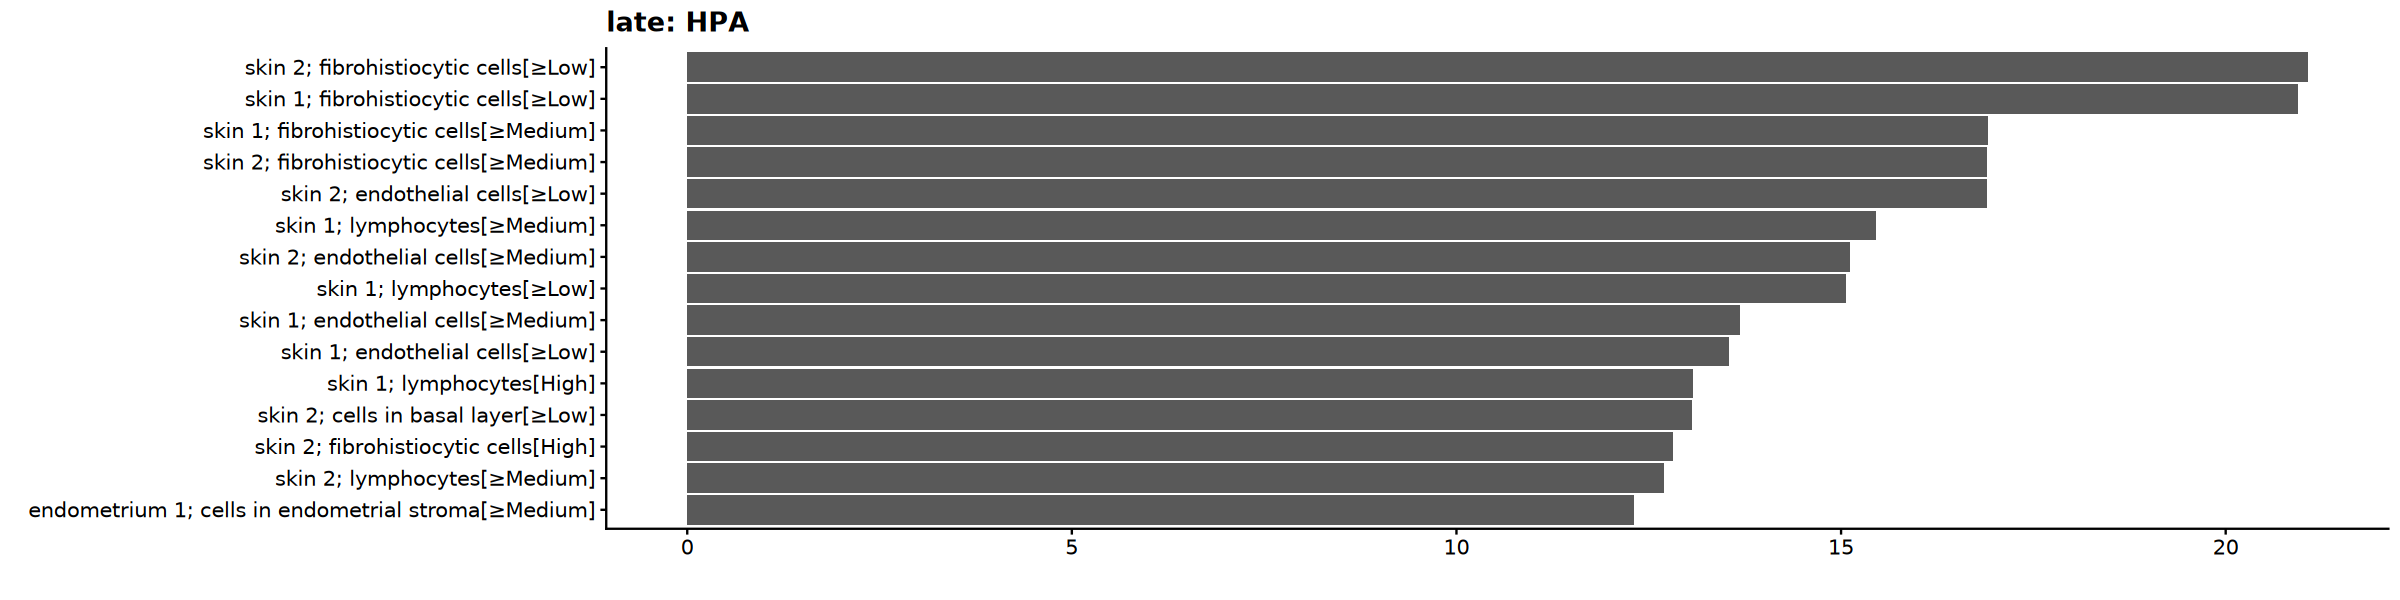

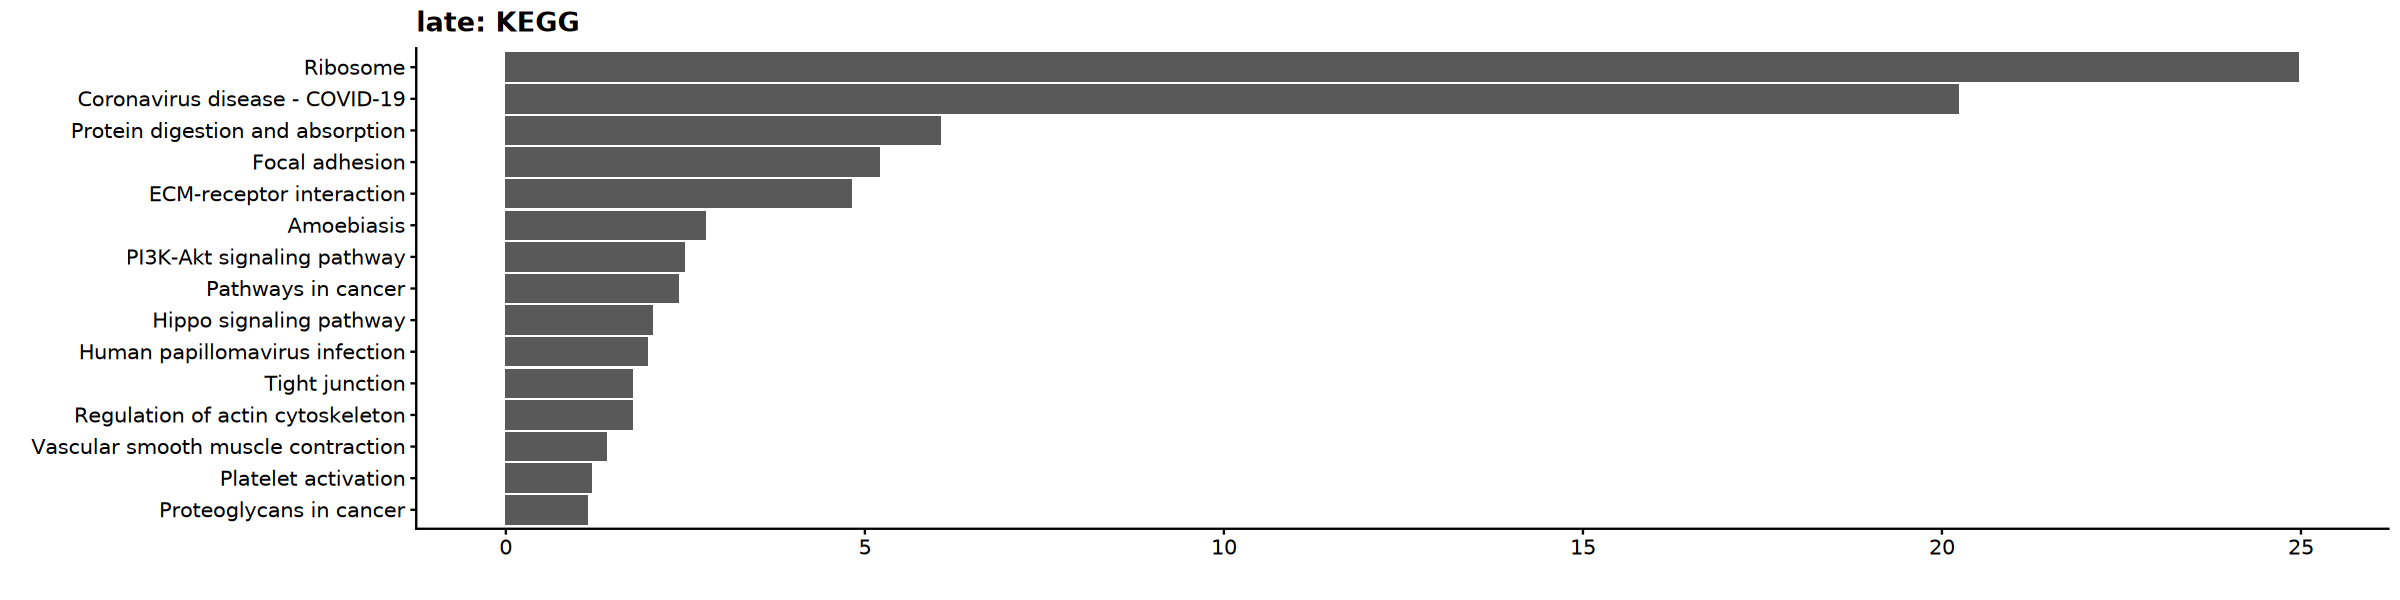

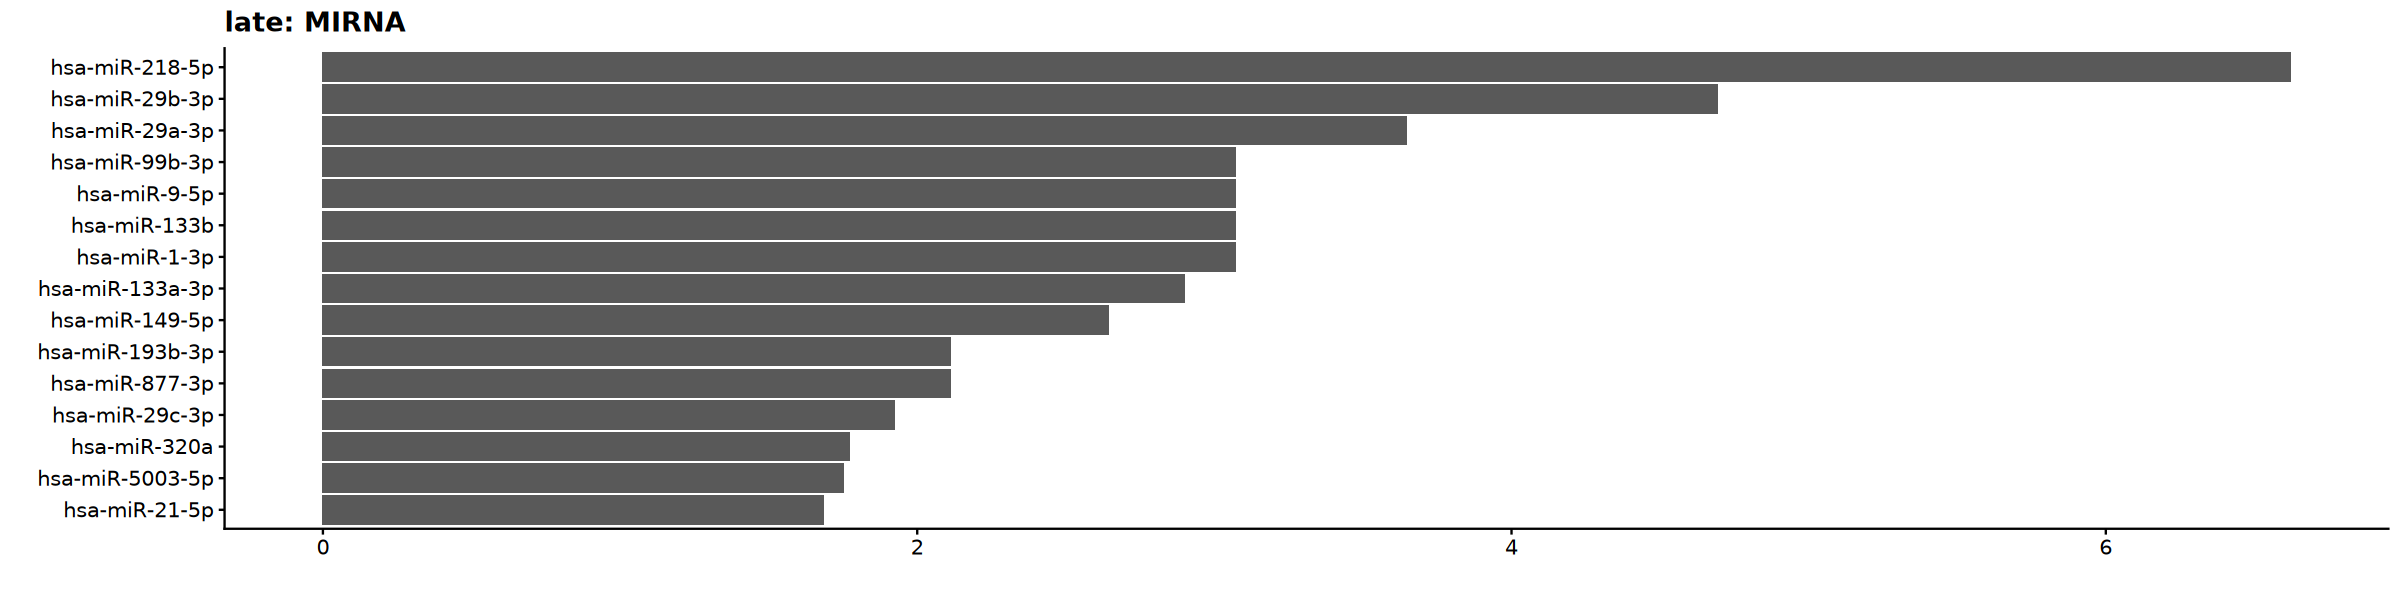

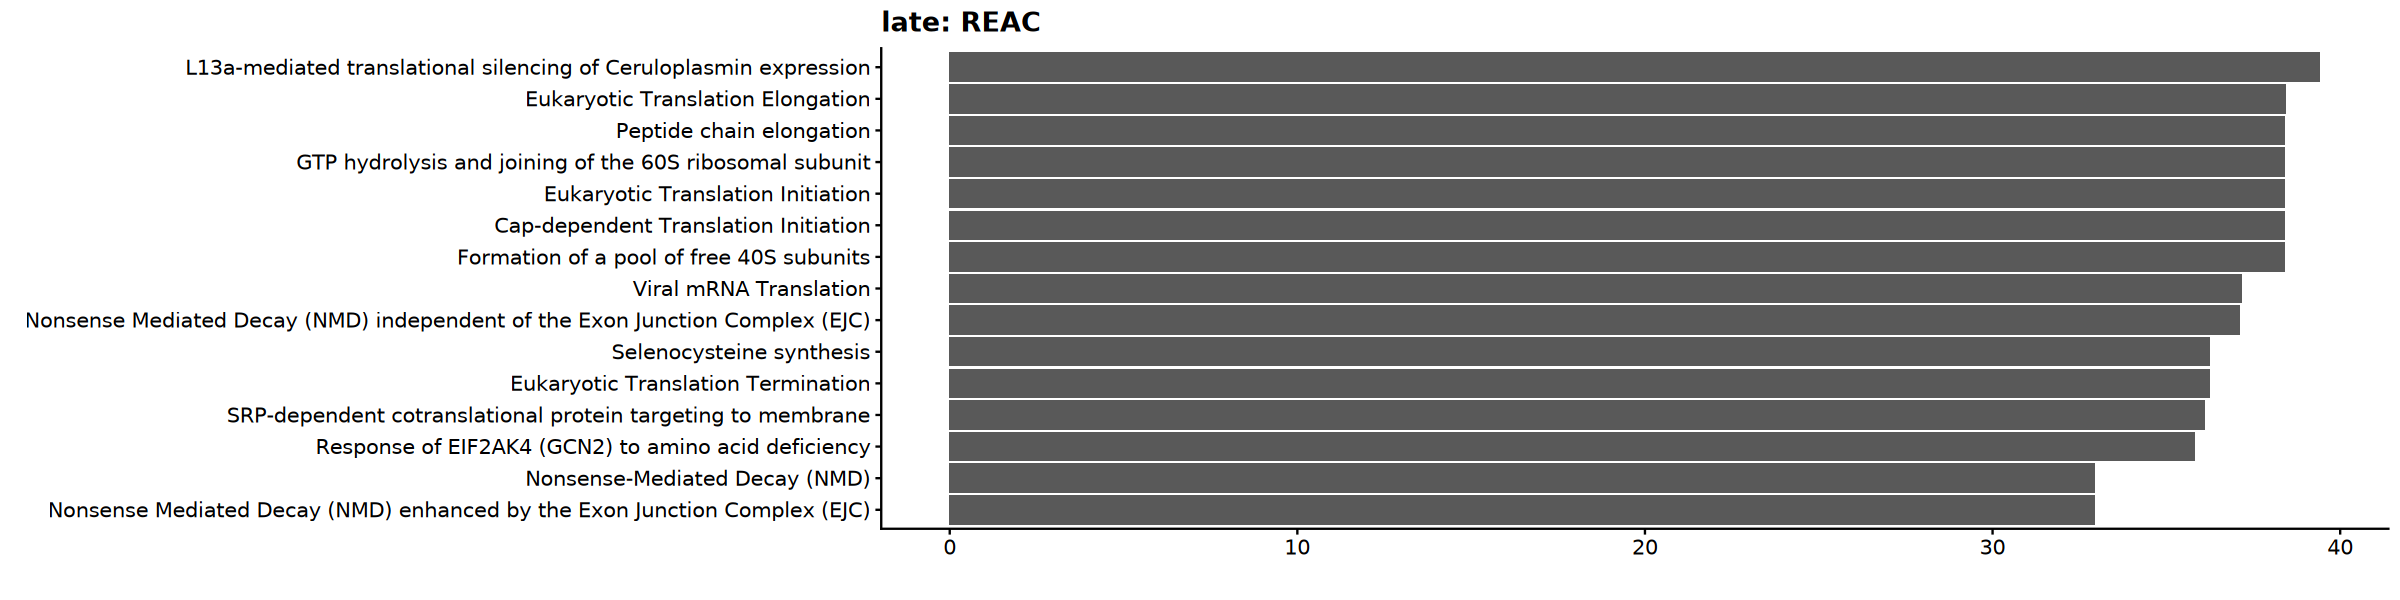

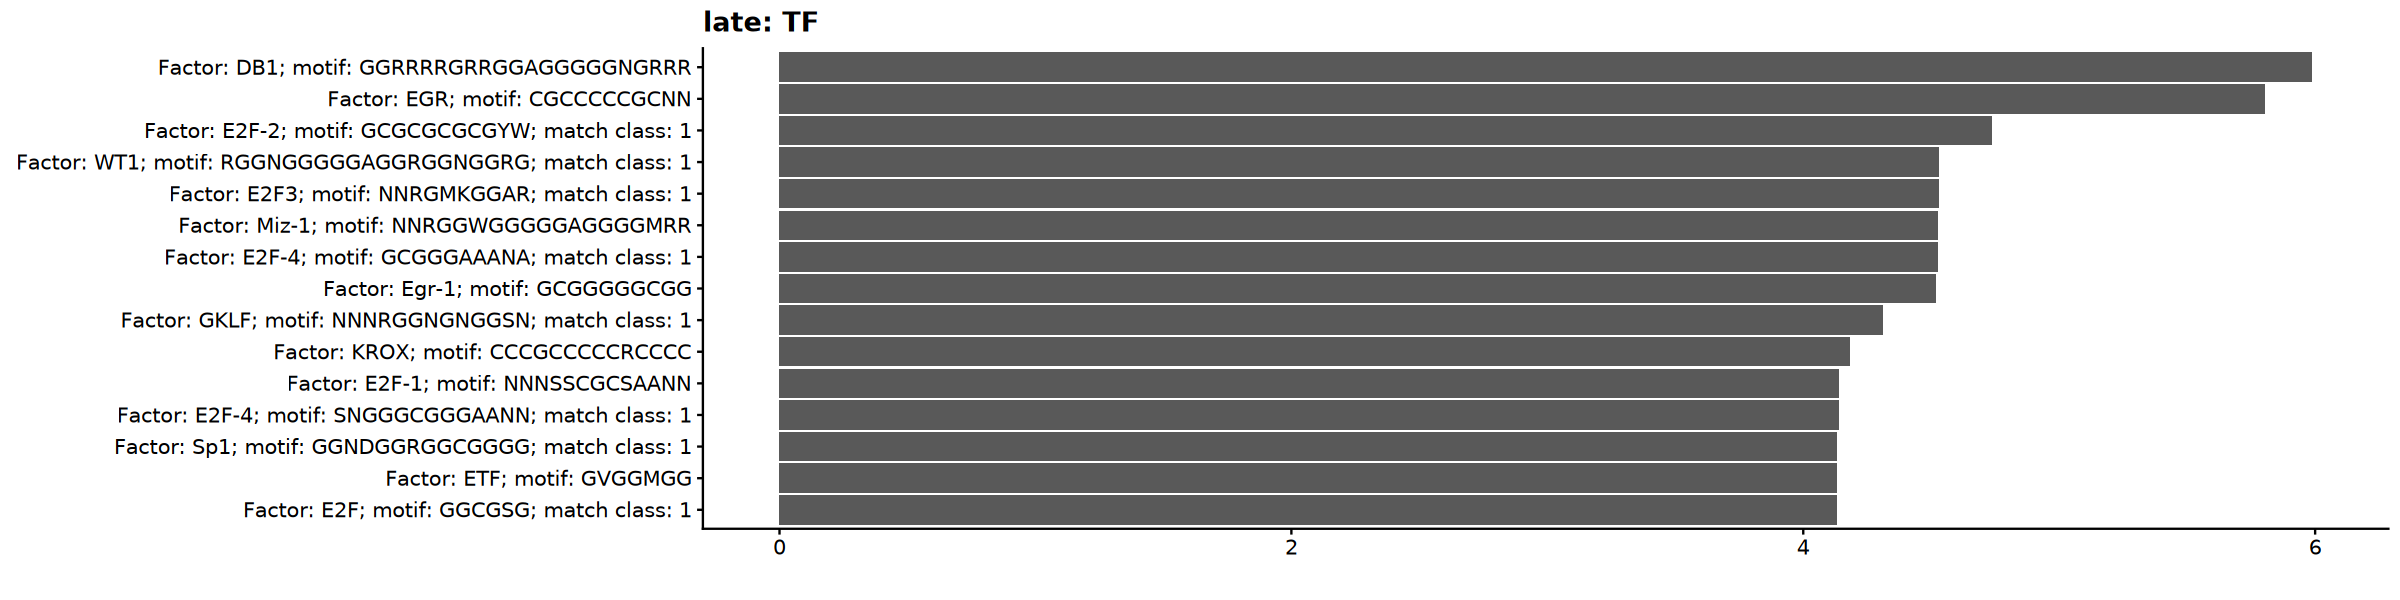

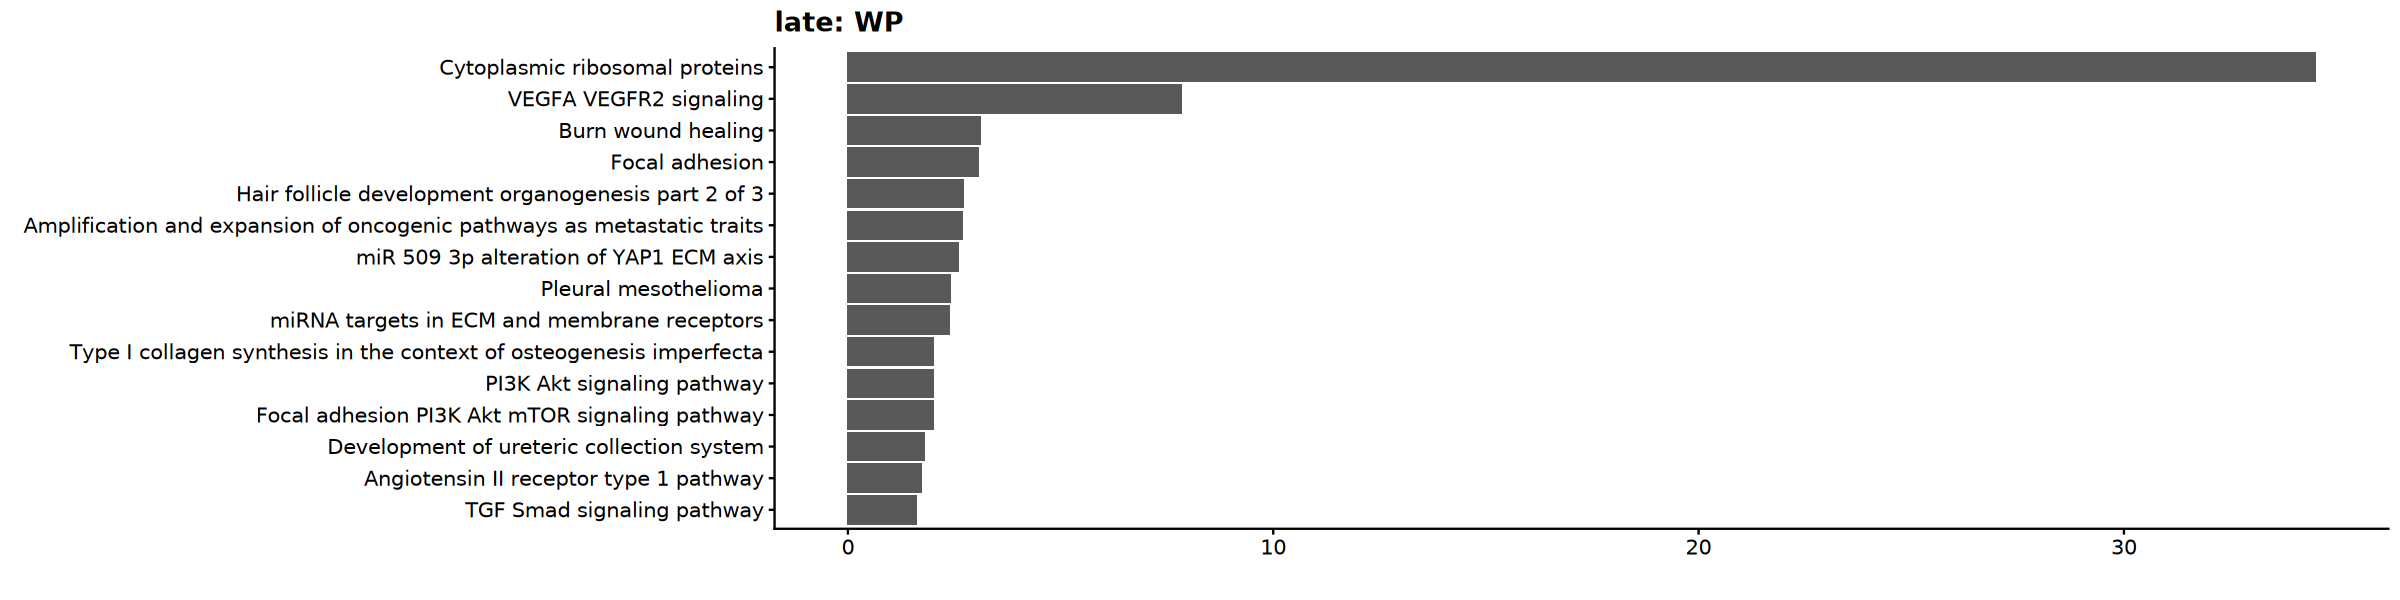

In [60]:
# plot top15 terms based on p-values
options(repr.plot.height = 5, repr.plot.width = 20)

for(c in unique(df_go$cluster)){
    for(s in unique(df_go$source)){
        
        df_go_sub <- df_go %>%
            subset(cluster == c & source == s) %>%
            mutate(p_value = -log10(p_value)) %>%
            slice_max(n = 15, order_by = p_value, with_ties = FALSE)
        
        p <- ggplot(data=df_go_sub, aes(x = reorder(term_name, p_value), y = p_value)) +
                geom_bar(stat = "identity") +
                coord_flip() +
                xlab("") + ylab("") +
                theme_cowplot() +
                ggtitle(glue::glue("{c}: {s}"))
    
        print(p)
    
    }
}